# Quantitative Model Training Notebook
This Notebook is designed to explore the behavior of the quantitative model equation by simulating synthetic datasets

In [38]:
# ==================================================
# define where your data is, and what files to import

# list directories for input data, figures and output files
Data_dir = './synthetic data/'
Fig_dir = './synthetic figures/'
Out_dir = './synthetic output/'
Ref_dir = './data/Standards/'

Technique = 'Raman'         # 'Raman' or 'FTIR'

# default parameters for data point locations
C_min = 10**-1  # min A concentration (in ppm)
C_max = 10**5   # max A concentration (in ppm)
C_samples = 7  # number of data points to generate

# number of values to generate per point
N_values = 100        # int, or list of ints with length C_samples

# define instrumental parameters for generating data
Params = {
    'I_v0': 1.,       # incident laser intensity
    'F_v1': 1.,       # instrument sensitivity factor at v1
    'F_v2': 1.,       # instrument sensitivity factor at v2
    'J_A1': 50.,      # raman cross-section for A, v1
    'J_A2': 5.,       # raman cross-section for A, v2
    'J_B1': 0.001,    # raman cross-section for B, v1
    'J_B2': 0.02,     # raman cross-section for B, v2
    'X_v1': 1.,       # sample attenuation factor at v1
    'X_v2': 1.        # sample attenuation factor at v2
}

Scenario = 1

# define noise levels
Dark_Noise = 100.     # st.dev. of fluctuations in absolute signal
Shot_Noise = 0.3      # st.dev. of fluctuations in relative signal

# background noise values is dark_noise * shot_noise
# peak noise is (background_noise + signal) * noise

# random number generator seed (set to None for true randomness, set to integer for replicable results)
Seed = 1001

# component materials in mixture
Components = ['A', 'B']

# specify which components to use as A and B
Evaluation_Components = ['A', 'B']

# Specify whether to bootstrap resample data (needed to estimate errors, requires 10+ spectra per sample)
Bootstrap = True
N_Bootstraps = 1000

Laser_Wavelength = '248'        # wavelength in nm, as str

In [39]:
# ==================================================
# this section imports necessary python modules

import os
import math
import glob
import datetime
import numpy as np
import pandas as pd
import lmfit as lmfit
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
from scipy.signal import savgol_filter
from mpl_toolkits.mplot3d import Axes3D

# import VibSpec module functions
from OSTRI_functions import *

# generate output folders
if not os.path.exists(Fig_dir):
    os.makedirs(Fig_dir)
if not os.path.exists(Out_dir):
    os.makedirs(Out_dir)

# ==================================================
# define any additional functions here

def generate_data(CA, CB, params={}, n_values=1, dark_noise=0., shot_noise=0., seed=None, return_all=False, tabs=0, debug=False):
    # function for generating synthetic intensity ratio data from input parameters
    
    # clean up input
    if type(seed) == float:
        seed = int(seed)
    if type(n_values) != int:
        n_values = int(n_values)
    if isinstance(CA, (int, float)):
        CA = np.asarray([CA], dtype=np.float64)
    if isinstance(CB, (int, float)):
        CB = np.asarray([CB], dtype=np.float64)
    for key in ['J_A1', 'J_A2', 'J_B1', 'J_B2', 'F_v1', 'F_v2', 'X_v1', 'X_v2', 'I_v0']:
        if key not in params.keys():
            raise Exception("params dict missing %s value!" % key)
        else:
            params[key] = np.float64(params[key])
    dark_noise = np.float64(dark_noise)
    shot_noise = np.float64(shot_noise)
    if debug == True:
        print("    "*(tabs+1), "N_dark: %0.1E" % dark_noise)
        print("    "*(tabs+1), "N_shot: %0.1E" % shot_noise)
    
    # get true parameter values
    truths = get_true_parameters(params['F_v1'] / params['F_v2'], params['X_v1'] / params['X_v2'],
                             params['J_A1'] / params['J_B2'], params['J_A2'] / params['J_A1'], params['J_B1'] / params['J_B2'])
    
    # generate x data
    CR = np.asarray(CA, dtype=np.float64) / np.asarray(CB, dtype=np.float64)
    
    # generate clean y data
    I1_clean = params['I_v0'] * params['F_v1'] * params['X_v1'] * (CA * params['J_A1'] + CB * params['J_B1'])
    I2_clean = params['I_v0'] * params['F_v2'] * params['X_v2'] * (CA * params['J_A2'] + CB * params['J_B2'])
    
    # expand arrays for bootstrapping
    I1_clean = np.tile(I1_clean[:, np.newaxis], (1, n_values))
    I2_clean = np.tile(I2_clean[:, np.newaxis], (1, n_values))
        
    # duplicate arrays for noise generation
    I1_noise = np.copy(I1_clean)
    I2_noise = np.copy(I2_clean)
    
    if seed == None:
        rng1 = np.random.default_rng()
        rng2 = np.random.default_rng()
    else:
        rng1 = np.random.default_rng(seed)
        rng2 = np.random.default_rng(2*seed)
    
    # add dark noise
    if dark_noise > 0:
        I1_noise += rng1.normal(0., dark_noise, size=np.shape(I1_noise))
        I2_noise += rng2.normal(0., dark_noise, size=np.shape(I2_noise))
    
    # add shot noise
    if shot_noise > 0:
        I1_noise *= rng1.normal(1., shot_noise, size=np.shape(I1_noise))
        I2_noise *= rng2.normal(1., shot_noise, size=np.shape(I2_noise))
        
    # get intensity ratios
    IR_clean = I1_clean / I2_clean
    IR_noise = I1_noise / I2_noise
    
    if debug == True:
        print("    "*(tabs), "generated data array:", np.shape(IR_clean), np.shape(IR_noise))
    
    # convert to data storage array
    if return_all == True:
        keys = ['params', 'truths', 'CA', 'CB', 'CR', 'I1_clean', 'I2_clean', 'IR_clean', 'I1_noise', 'I2_noise', 'IR_noise']
        arrays = [params, truths, CA, CB, CR, I1_clean, I2_clean, IR_clean, I1_noise, I2_noise, IR_noise]
    else:
        keys = ['params', 'truths', 'CR', 'IR_clean', 'IR_noise']
        arrays = [params, truths, CR, IR_clean, IR_noise]
        
    # return results
    return {key: array for key, array in zip(keys, arrays)}

def get_true_parameters(F=0, X=0, J=0, A=0, B=0):
    truths = {
        'FXJ': F*X*J,
        'FXB': F*X*B,
        'JA': J*A,
        'FXJ_JA': np.inf
    }
    if J*A > 0:
        truths['FXJ_JA'] = (F*X*J) / (J*A)
    return truths

# ==================================================
# automatically adjust parameters based on chosen scenario

if Scenario in [2,4]:
    Params['J_A2'] = 0.
if Scenario in [3,4]:
    Params['J_B1'] = 0.

Truths = get_true_parameters(Params['F_v1'] / Params['F_v2'], Params['X_v1'] / Params['X_v2'],
                             Params['J_A1'] / Params['J_B2'], Params['J_A2'] / Params['J_A1'], Params['J_B1'] / Params['J_B2'])

print()
print("input data parameters")
for key, val in Truths.items():
    print("%6s: %0.1E" % (key, val))
    
if Scenario == 1:
    X_Lims = {'FXJ': (2000,3000), 'FXB': (0.03, 0.07), 'JA': (150, 350), 'FXJ_JA': (None, None)}
elif Scenario == 2:
    X_Lims = {'FXJ': (2000,3000), 'FXB': (0.03, 0.07), 'JA': (-1, 2), 'FXJ_JA': (None, None)}
elif Scenario == 3:
    X_Lims = {'FXJ': (2000,3000), 'FXB': (-0.0001, 0.0001), 'JA': (150, 350), 'FXJ_JA': (None, None)}
else:
    X_Lims = {'FXJ': (2000,3000), 'FXB': (-0.0001, 0.0001), 'JA': (-1, 2), 'FXJ_JA': (None, None)}


input data parameters
   FXJ: 2.5E+03
   FXB: 5.0E-02
    JA: 2.5E+02
FXJ_JA: 1.0E+01


     N_dark: 1.0E+02
     N_shot: 3.0E-01
 generated data array: (10, 1000) (10, 1000)
(10, 1000)
I1_noise range (log): 0.0 4.0
I1_noise stdev: 0.31 of mean
    95% of data within +/- 0.63x
I2_noise range (log): 2.0 5.0
I2_noise stdev: 0.30 of mean
    95% of data within +/- 0.59x
IR_noise range (log): -4.0 2.0
IR_noise stdev: 1.08 of mean
    95% of data within +/- 2.17x


/var/folders/54/d2hxt0352h1fr522wqnkkz7c0000gn/T/ipykernel_15995/1466406082.py:24: RuntimeWarning: invalid value encountered in log10
  plt.axvline(np.log10(y_av[0] - y_std[0]), c='k', linestyle=':')


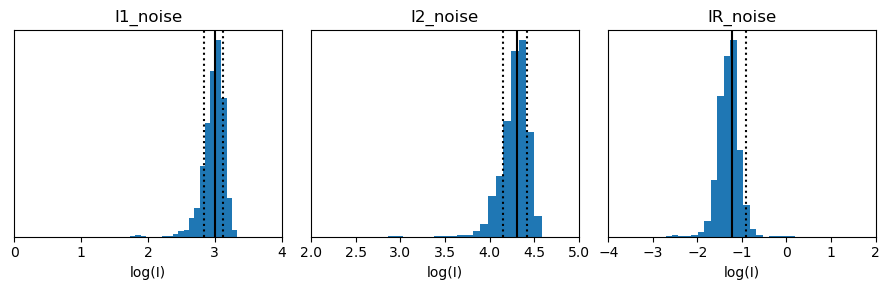

In [40]:
CA = np.logspace(-7, -1, 10)
CB = 10**6 - CA

data = generate_data(CA, CB, Params, n_values=1000, dark_noise=Dark_Noise, shot_noise=Shot_Noise, seed=626, return_all=True, debug=True)
print(np.shape(data['I1_noise']))

plt.figure(figsize=(9,3))
for i, key in enumerate(['I1_noise', 'I2_noise', 'IR_noise']):
    plt.subplot(1, 3, i+1)
    plt.yticks([])
    y = data[key]
    check = np.logical_or(y <= 0, np.isinf(y))
    y[check] = np.nan
    x_min = np.floor(np.log10(np.nanmin(y)))
    x_max = np.ceil(np.log10(np.nanmax(y)))
    print("%s range (log):" % key, x_min, x_max)
    plt.xlim(x_min, x_max)
    plt.xlabel("log(I)")
    plt.title(key)
    plt.hist(np.log10(y[0]), bins=20)
    y_av = np.nanmean(y, axis=1)
    y_std = np.nanstd(y, axis=1)
    plt.axvline(np.log10(y_av[0]), c='k')
    plt.axvline(np.log10(y_av[0] - y_std[0]), c='k', linestyle=':')
    plt.axvline(np.log10(y_av[0] + y_std[0]), c='k', linestyle=':')
    print("%s stdev: %0.2f of mean" % (key, y_std[0]/y_av[0]))
    print("    95%% of data within +/- %0.2fx" % (2*y_std[0]/y_av[0]))
plt.tight_layout()
plt.show()

[1.00000010e-07 1.00000100e-06 1.00001000e-05 1.00010001e-04
 1.00100100e-03 1.01010101e-02 1.11111111e-01]


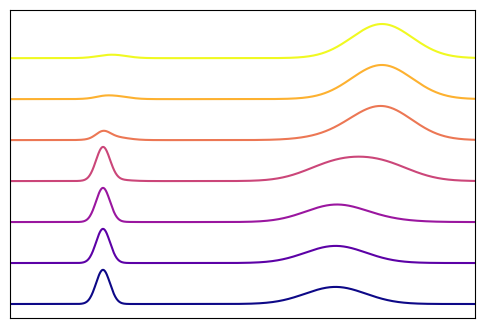

In [75]:
# plot figure for graphical abstract

CA = np.logspace(np.log10(C_min), np.log10(C_max), int(C_samples))
CB = 1000000. - CA
CR = CA / CB

print(CR)

norm = mpl.colors.LogNorm(vmin=np.amin(CR), vmax=np.amax(CR))
cmap = mpl.cm.ScalarMappable(norm=norm, cmap='plasma')
cmap.set_array([])

Peaks = {
    'A1': {'center': 1600, 'sigma': 65, 'amplitude': Params['F_v1'] * Params['X_v1'] * 50, 'C': CA},
    'A2': {'center': 1020, 'sigma': 30, 'amplitude': Params['F_v2'] * Params['X_v2'] * 5, 'C': CA},
    'B1': {'center': 1500, 'sigma': 65, 'amplitude': Params['F_v1'] * Params['X_v1'] * 0.005, 'C': CB},
    'B2': {'center': 1000, 'sigma': 15, 'amplitude': Params['F_v2'] * Params['X_v2'] * 0.01, 'C': CB}
}

offset = 1.2

log = False

plt.figure(figsize=(6,4))
x_temp = np.linspace(800, 1800, 1000)
for count, (C_A, C_B, C_R) in enumerate(zip(CA, CB, CR)):
    y_temp = []
    peak_params = lmfit.Parameters()
    peak_params.add("gradient", 0)
    peak_params.add("intercept", 0)
    for i2, (peak, props) in enumerate(Peaks.items()):
        peak_params.add("center_%s" % i2, props['center'])
        peak_params.add("amplitude_%s" % i2, props['amplitude'] * props['C'][count])
        peak_params.add("sigma_%s" % i2, props['sigma'])
    curve = multiG_curve(peak_params, x_temp, range(4))
    if log == True:
        curve /= np.amax(curve)
        curve *= offset**count
    else:
        curve /= np.amax(curve)
        curve += offset*count
    plt.plot(x_temp, curve, c=cmap.to_rgba(C_R))
plt.xlim(800, 1800)
if log == True:
    plt.yscale('log')
plt.xticks([])
plt.yticks([])
plt.savefig("%sgraphic.svg" % Fig_dir, dpi=300)
plt.show()

## Bootstrap Training on Standard Data

BOOTSTRAP FITTING OF DATA

SCENARIO 1

    input data parameters
           FXJ: 2.5E+03
           FXB: 5.0E-02
            JA: 2.5E+02
        FXJ_JA: 1.0E+01

        generating data...

        fitting data...

 bootstrapping input data, N = 1000
      input data array: (20, 100)
     output data array: (20, 1000)

 proceeding with bootstrap modelling, N = 1000

 input data:
(20,) (20,)
     nans: 0
     infs: 0
     <=0:  0
     points trimmed: 0
 input parameters:
Name       Value      Min      Max   Stderr     Vary     Expr Brute_Step
FXB         0.01        0      inf     None     True     None     None
FXJ            1    1e-40      inf     None     True     None     None
FXJ_JA       100     -inf      inf     None    False   FXJ/JA     None
JA          0.01        0      inf     None     True     None     None
log            1        0        1     None    False     None     None
None
 proceeding with fit
 fit status:  Optimization terminated successfully.
 fitted parameters:

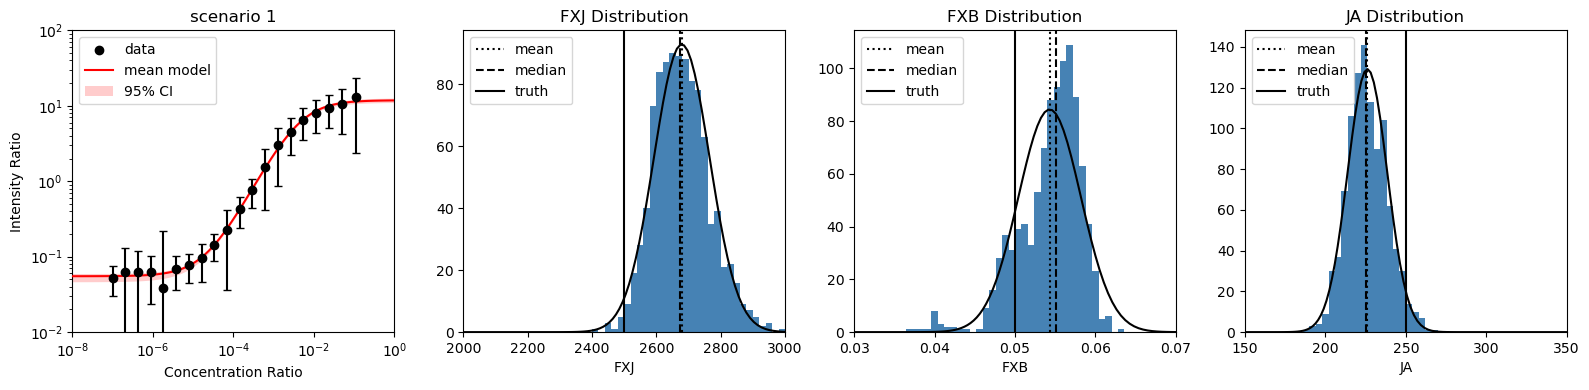


     end of plot_quantmodel_summary() function
           FXJ (16-84%): 2.67E+03 (2.59E+03 - 2.76E+03)
           FXB (16-84%): 5.50E-02 (5.04E-02 - 5.78E-02)
            JA (16-84%): 2.25E+02 (2.14E+02 - 2.38E+02)
        FXJ_JA (16-84%): 1.19E+01 (1.15E+01 - 1.23E+01)
DONE


In [4]:
# skip this section?
skip = False

# print debug messages?
debug = True

# plot true parameter values as lines?
plot_truths = True

show_text = False

# show plots in viewer?
show_plot = True

# save plots to file?
save_plot = True

# plot covariances from bootstrapping?
plot_covariance = False

Add_Outliers = 0

# set up data storage arrays
data = {}
fits = {}

xo, yo, w, h = (0.18, 0.92, 0.35, 0.06)

if skip == True:
    print("SKIPPING BOOTSTRAP FITTING")
else:
    print("BOOTSTRAP FITTING OF DATA")

    # generate input concentrations (in ppm)
    CA = np.logspace(np.log10(C_min), np.log10(C_max), int(C_samples))
    CB = 1000000. - CA
    
    print()
    print("SCENARIO %s" % Scenario)
    
    # key, title for this dataset
    d_key = 'scenario %s' % (Scenario)
    title = 'scenario %s' % (Scenario)

    # ==================================================
    # define parameters
    
    print()
    print("    input data parameters")
    for key, val in Truths.items():
        print("        %6s: %0.1E" % (key, val))
        
    # ==================================================
    # generate dataset

    print()
    print("        generating data...")
    data[d_key] = generate_data(CA, CB, Params, N_values, dark_noise=Dark_Noise, shot_noise=Shot_Noise,
                                seed=Seed, return_all=True, tabs=1)
    
    if Add_Outliers > 0:
        rng1 = np.random.default_rng(Seed)
        i = rng.choice(range(C_samples), size=Add_Outliers, replace=False)
        for key in ['I1_clean', 'I1_noise', 'IR_clean', 'IR_noise']:
            data[d_key][key][i,:] /= 100

    # ==================================================
    # fit ratio

    print()
    print("        fitting data...")
    x = data[d_key]['CR']
    y = data[d_key]['IR_noise']
    fits[d_key] = bootstrap_intensity_fit_script(x, y, title=title, truths=Truths, x_lims=X_Lims, plot_covariance=plot_covariance,
                                    seed=Seed, show_text=show_text, show_plot=show_plot, save_plot=save_plot, fig_dir=Fig_dir, debug=debug)

    for key in ['FXJ', 'FXB', 'JA', 'FXJ_JA']:
        param = fits[d_key][key]
        print("        %6s (16-84%%): %0.2E (%0.2E - %0.2E)" % (key, param.median, np.percentile(param.bootstrap, 16), np.percentile(param.bootstrap, 84)))
        
    print("DONE")

## Predict Concentrations Using Model

MAKING PREDICTIONS
FXB: 5.5E-02
[1.e-03 1.e-06]

CR = 1.0E-03
IR values: (1, 100)
      mean: 2.3E+00 +/- 1.1E+00
    median: 2.1E+00
     1-99%: 6.1E-01 - 6.3E+00
    normality test p value: 0.00000
    <FXB: 0.00
(1, 1000)
x-range: (np.float64(-0.24373087639807078), np.float64(5.279180235781611))
temp: (1, 100)
hist: (50,)

CR from clean IR, median model parameters: 9.0E-04
x-range: (np.float64(-0.0003377381900202015), np.float64(0.002856353275627679))
(1, 1000)

predicted CR (model): (1, 1000)
      mean: 8.96E-04 +/- 2.63E-05
    median: 8.96E-04
       IQR: 3.75E-05
    16-84%: 8.70E-04 - 9.23E-04
  failures: 0.00
    normality test p value: 0.08316
(1, 100000)

predicted CR (actual): (1, 100000)
      mean: 1.11E-03 +/- 8.49E-04
    median: 9.10E-04
       IQR: 5.74E-04
    16-84%: 5.98E-04 - 1.40E-03
  failures: 0.00
    normality test p value: 0.00000
(1, 1000000)

predicted CR (normal): (1, 1000000)
      mean: 1.09E-03 +/- 6.50E-04
    median: 1.02E-03
       IQR: 8.11E-04
  

/var/folders/54/d2hxt0352h1fr522wqnkkz7c0000gn/T/ipykernel_20765/1568210849.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("      mean: %0.1E +/- %0.1E" % (test_IR_mean, test_IR_std))
/var/folders/54/d2hxt0352h1fr522wqnkkz7c0000gn/T/ipykernel_20765/1568210849.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("    median: %0.1E" % (test_IR_median))
/var/folders/54/d2hxt0352h1fr522wqnkkz7c0000gn/T/ipykernel_20765/1568210849.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operati

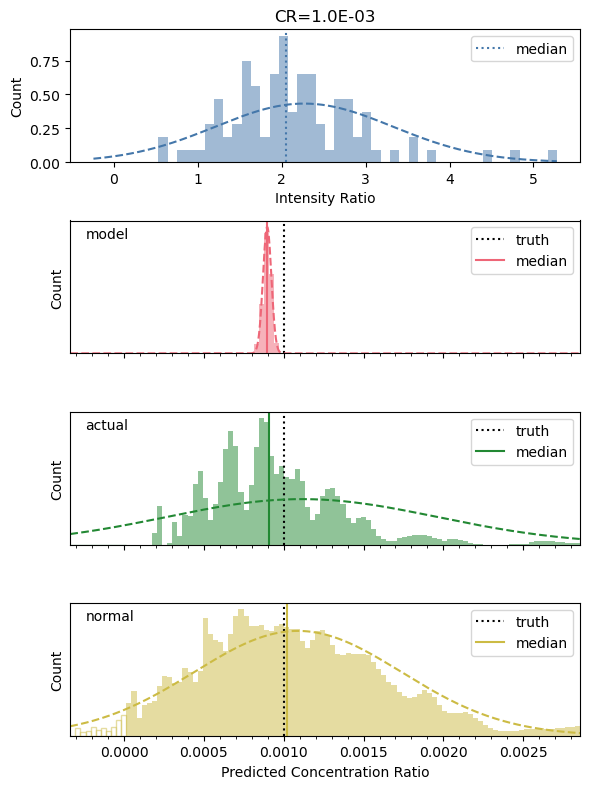


CR = 1.0E-06
IR values: (1, 100)
      mean: 6.0E-02 +/- 4.1E-02
    median: 4.9E-02
     1-99%: 2.3E-02 - 1.8E-01
    normality test p value: 0.00000
    <FXB: 64.00
(1, 1000)
x-range: (np.float64(-0.012407027018817102), np.float64(0.164213676126884))
temp: (1, 100)
hist: (50,)

CR from clean IR, median model parameters: -6.8E-07
x-range: (np.float64(-2.5255901876415943e-05), np.float64(4.310701460253687e-05))
(1, 1000)

predicted CR (model): (1, 1000)
      mean: -7.04E-07 +/- 1.45E-06
    median: -9.62E-07
       IQR: 1.76E-06
    16-84%: -2.02E-06 - 7.81E-07
  failures: 73.90
    normality test p value: 0.00000
(1, 100000)

predicted CR (actual): (1, 100000)
      mean: 2.33E-06 +/- 1.57E-05
    median: -1.70E-06
       IQR: 1.01E-05
    16-84%: -7.59E-06 - 9.50E-06
  failures: 60.80
    normality test p value: 0.00000
(1, 1000000)

predicted CR (normal): (1, 1000000)
      mean: 2.17E-06 +/- 1.58E-05
    median: 2.18E-06
       IQR: 2.08E-05
    16-84%: -1.30E-05 - 1.71E-05
  fai

/var/folders/54/d2hxt0352h1fr522wqnkkz7c0000gn/T/ipykernel_20765/1568210849.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("      mean: %0.1E +/- %0.1E" % (test_IR_mean, test_IR_std))
/var/folders/54/d2hxt0352h1fr522wqnkkz7c0000gn/T/ipykernel_20765/1568210849.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("    median: %0.1E" % (test_IR_median))
/var/folders/54/d2hxt0352h1fr522wqnkkz7c0000gn/T/ipykernel_20765/1568210849.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operati

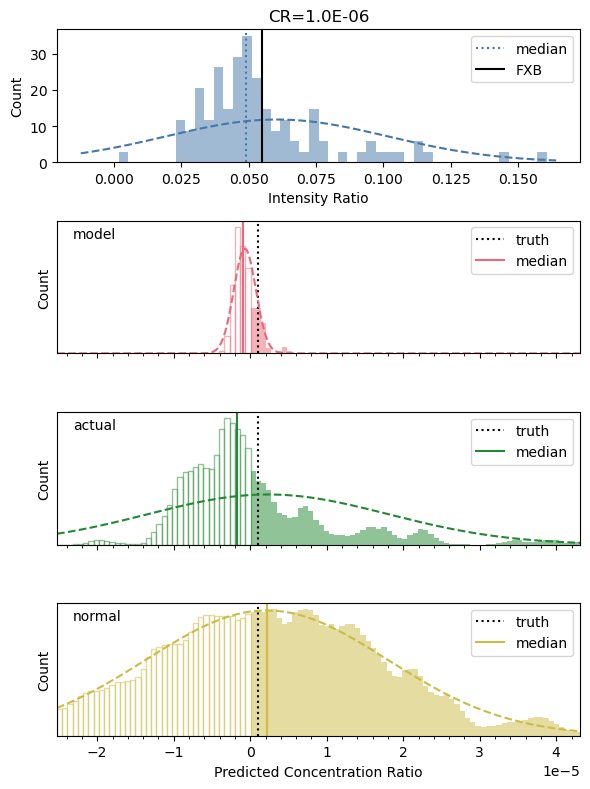

In [5]:
from scipy.stats import normaltest

test_CRs = [10**-3, 10**-6]

limit = 'lower'

if skip == True:
    print("SKIPPING PREDICTION")
else:
    print("MAKING PREDICTIONS")
    
    model = fits[d_key]
    
    print("FXB: %0.1E" % model['FXB'].median)
    
    test_CRs = np.asarray(test_CRs)
    test_CAs = (10**6 * test_CRs) / (test_CRs + 1)
    test_CBs = 10**6 / (test_CRs + 1)
    print(test_CRs)
    
    for test_CR in test_CRs:
        print()
        print("CR = %0.1E" % test_CR)
        
        # generate IR data for this CR
        temp = generate_data(
            (10**6 * test_CR) / (test_CR + 1),
            10**6 / (test_CR + 1),
            Params,
            100,
            dark_noise=Dark_Noise,
            shot_noise=Shot_Noise,
            seed = int(100/test_CR),
            return_all=True
        )
        test_IR_clean = np.nanmean(temp['IR_clean'], axis=-1)
        test_IR_noise = temp['IR_noise']

        test_IR_median = np.nanmedian(test_IR_noise, axis=-1)
        test_IR_mean = np.nanmean(test_IR_noise, axis=-1)
        test_IR_std = np.nanstd(test_IR_noise, axis=-1)
        test_IR_pc1 = np.nanpercentile(test_IR_noise, 1, axis=-1)
        test_IR_pc99 = np.nanpercentile(test_IR_noise, 99, axis=-1)

        print("IR values:", np.shape(test_IR_noise))
        print("      mean: %0.1E +/- %0.1E" % (test_IR_mean, test_IR_std))
        print("    median: %0.1E" % (test_IR_median))
        print("     1-99%%: %0.1E - %0.1E" % (test_IR_pc1, test_IR_pc99))

        test = normaltest(test_IR_noise[0])
        print("    normality test p value: %0.5f" % test.pvalue)
        
        check = test_IR_noise[0] < model['FXB'].median
        print("    <FXB: %3.2f" % (100*np.count_nonzero(check)/np.size(test_IR_noise[0])))
        
        # generate normally distributed data
        rng = np.random.default_rng(626)
        test_IR_normal = rng.normal(test_IR_mean, test_IR_std, (1,1000))
        print(np.shape(test_IR_normal))
        
        # set up subplots
        fig, axs = plt.subplots(4, 1, figsize=(6,8), subplot_kw={'ylabel': 'Count'})
        ax = axs[0]
        ax.set_title("CR=%0.1E" % test_CR)
        ax.set_xlabel("Intensity Ratio")
        
        # get x_range for IR plot
        lower = np.nanpercentile(test_IR_noise[0], 16)
        upper = np.nanpercentile(test_IR_noise[0], 84)
        lower = test_IR_median[0] - 4*(test_IR_median[0] - lower)
        upper = test_IR_median[0] + 4*(upper - test_IR_median[0])
        x_range = (lower, upper)
        print("x-range:", x_range)
        
        # determine whether to include FXB distribution in IR plot
        if model['FXB'].pc99 > test_IR_pc1:
            temp = [test_IR_noise[0]]
            colours = [Colour_List[0]]
        else:
            temp = [test_IR_noise[0]]
            colours = [Colour_List[0]]
        print("temp:", np.shape(temp))
        
        # get histograms
        hist, bins, patches = ax.hist(temp, range=x_range, bins=50, density=True, color=colours, alpha=0.5)
        print("hist:", np.shape(hist))
        ax.axvline(test_IR_median, c=colours[0], linestyle=':', label='median')
        
        ### hist, bins, patches = ax.hist(test_IR_noise[0], weights=weights, range=x_range, bins=50, facecolor=Colour_List[0], alpha=0.5)
        ### plt.setp([p for p, b in zip(patches, bins) if b < model['FXB'].median], facecolor='w', edgecolor=Colour_List[0])

        # plot gaussian fit
        x_temp = np.linspace(bins[0], bins[-1], 1000)
        # plot expected normal distribution for mean, std
        params = lmfit.Parameters()
        params.add('gradient', value=0., vary=False)
        params.add('intercept', value=0., vary=False)
        params.add('center_%s' % 0, value=test_IR_mean, vary=False)
        params.add('amplitude_%s' % 0, value=np.nanmax(hist))
        params.add('sigma_%s' % 0, value=test_IR_std, vary=False)
        fit = lmfit.minimize(multiG_fit, params, args=((bins[1:]+bins[:-1])/2, hist, [0]))
        y_temp = multiG_curve(fit.params, x_temp, [0])
        ax.plot(x_temp, y_temp, c=Colour_List[0], linestyle='--')
        
        if model['FXB'].median > test_IR_pc1:
            ax.axvline(model['FXB'].median, c='k', linestyle='-', label='FXB')
            
        ax.legend()

        predicted_CR = concentration_curve(model, test_IR_clean)
        print()
        print("CR from clean IR, median model parameters: %0.1E" % predicted_CR)
        
        # get x_range for CR plots
        bins = 100
        predicted_CR = predict_concentration(model, test_IR_noise, seed=Seed, return_all=True, clean_output=False)[0]
        median = np.nanmedian(predicted_CR)
        lower = np.nanpercentile(predicted_CR, 16)
        upper = np.nanpercentile(predicted_CR, 84)
        lower = median - 4*(median - lower)
        upper = median + 4*(upper - median)
        x_range = (lower, upper)
        print("x-range:", x_range)
        
        for test_data, label, colour, ax in zip([test_IR_clean, test_IR_noise, test_IR_normal], ['model', 'actual', 'normal'], Colour_List[1:], axs[1:]):
            # 

            # plot reference lines, add text labels
            ax.axvline(test_CR, c='k', linestyle=':', label='truth')
            ### ax.axvline(0, c='k', linestyle='-', label='0')

            # make CR predictions
            predicted_CR = predict_concentration(model, test_data, seed=Seed, return_all=True, clean_output=False)
            
            # check for failed predictions
            fail_check = np.logical_or(predicted_CR < 0, np.isinf(predicted_CR))
            failures = np.count_nonzero(np.logical_or(fail_check, np.isnan(predicted_CR)), axis=-1)
            
            predicted_CR_median = np.nanmedian(predicted_CR, axis=-1)
            predicted_CR_mean = np.nanmean(predicted_CR, axis=-1)
            predicted_CR_std = np.nanstd(predicted_CR, axis=-1)
            predicted_CR_pc16 = np.nanpercentile(predicted_CR, 16, axis=-1)
            predicted_CR_pc84 = np.nanpercentile(predicted_CR, 84, axis=-1)

            print(np.shape(predicted_CR))
            print()
            print("predicted CR (%s):" % label, np.shape(predicted_CR))
            print("      mean: %0.2E +/- %0.2E" % (predicted_CR_mean, predicted_CR_std))
            print("    median: %0.2E" % (predicted_CR_median))
            print("       IQR: %0.2E" % (np.nanpercentile(predicted_CR, 75, axis=-1) - np.nanpercentile(predicted_CR, 25, axis=-1)))
            print("    16-84%%: %0.2E - %0.2E" % (predicted_CR_pc16, predicted_CR_pc84))
            print("  failures: %0.2f" % (100*failures/np.size(predicted_CR, axis=-1)))

            text = [
                "med.: %0.1E" % predicted_CR_median,
                "16th: %0.1E" % predicted_CR_pc16,
                "84th: %0.1E" % predicted_CR_pc84,
            ]
            ax.text(0.03, 0.95, label, ha='left', va='top', transform=ax.transAxes)
            ### ax.text(0.2, 0.85, "\n".join(text), ha='right', va='top', transform=ax.transAxes)

            test = normaltest(predicted_CR[0])
            print("    normality test p value: %0.5f" % test.pvalue)

            ax.axvline(predicted_CR_median, c=colour, linestyle='-', label="median")
            hist, bins, patches = ax.hist(predicted_CR[0], range=x_range, bins=bins, density=True,
                                          facecolor=colour, alpha=0.5)
            plt.setp([p for p, b in zip(patches, bins) if b < 0], facecolor='w', edgecolor=colour)

            x_temp = np.linspace(bins[0], bins[-1], 1000)
            # plot expected normal distribution for mean, std
            params = lmfit.Parameters()
            params.add('gradient', value=0., vary=False)
            params.add('intercept', value=0., vary=False)
            params.add('center_%s' % 0, value=predicted_CR_mean, vary=False)
            params.add('amplitude_%s' % 0, value=np.nanmax(hist))
            params.add('sigma_%s' % 0, value=predicted_CR_std, vary=False)
            fit = lmfit.minimize(multiG_fit, params, args=((bins[1:]+bins[:-1])/2, hist, [0]))
            y_temp = multiG_curve(fit.params, x_temp, [0])
            ax.plot(x_temp, y_temp, c=colour, linestyle='--')

            ax.set_xlim(x_range)
            ### ax.set_xscale('log')
            ax.set_yticks([])
            if ax == axs.flat[-1]:
                ax.set_xlabel("Predicted Concentration Ratio")
            else:
                ax.set_xticklabels([])
            ax.legend()
            ax.minorticks_on()
    
        # finish figure

        plt.tight_layout()
        if save_plot == True:
            plt.savefig("%sCR=%0.1E_prediction-distributions.png" % (Fig_dir, test_CR), dpi=300)
            plt.savefig("%sCR=%0.1E_prediction-distributions.svg" % (Fig_dir, test_CR), dpi=300)
        if show_plot == True:
            plt.show()
        else:
            plt.close()

## Estimate Limits

ESTIMATING LIMITS OF DETECTION, QUANTIFICATION

lower limits:

median FXB: 5.5E-02
    LD (model): 2.1E-06
    LD (noise): 2.9E-06
    LQ (model): 7.1E-06
    LQ (noise): 7.9E-06
(3, 1000)
x range: 0.03886776199464501 - 0.08005532174400008
critical value: 6.1E-02

blank model
    CR = 0.0E+00
    IR: (1000,)
    median IR: 5.5E-02
    FN rate: 99.0

LOD model
    CR = 2.1E-06
    IR: (1000,)
    median IR: 6.1E-02
    FN rate: 50.0

LOQ model
    CR = 7.1E-06
    IR: (1000,)
    median IR: 7.4E-02
    FN rate: 1.0
(3, 1000000)
x range: 0.037743150730004275 - 0.08452605932074615
critical value: 6.3E-02

blank noise
    CR = 0.0E+00
    IR: (1000000,)
    median IR: 5.5E-02
    FN rate: 99.0

LOD noise
    CR = 2.9E-06
    IR: (1000000,)
    median IR: 6.3E-02
    FN rate: 50.0

LOQ noise
    CR = 7.9E-06
    IR: (1000000,)
    median IR: 7.6E-02
    FN rate: 1.0


/var/folders/54/d2hxt0352h1fr522wqnkkz7c0000gn/T/ipykernel_20765/4088462984.py:118: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/joby/Documents/JPL Archive/Quantitative Raman/OSTRI_functions.py:3903: RuntimeWarning: invalid value encountered in divide
  IR = (params["FXJ"] * CR + params["FXB"]) / (params["JA"] * CR + 1)



upper limits:

median FXJ_JA: 1.2E+01
    LD (model): 5.7E-02
    LD (noise): 4.6E-02
    LQ (model): 2.9E-02
    LQ (noise): 2.3E-02
(3, 1000)
x range: 9.603303666803233 - 12.948466945436582
critical value: 1.1E+01

blank model
    CR = INF
    IR: (1000,)
    median IR: 1.2E+01
    FN rate: 99.0

LOD model
    CR = 5.7E-02
    IR: (1000,)
    median IR: 1.1E+01
    FN rate: 50.1

LOQ model
    CR = 2.9E-02
    IR: (1000,)
    median IR: 1.0E+01
    FN rate: 1.1
(3, 1000000)
x range: 9.128513510557863 - 13.327488751526586
critical value: 1.1E+01

blank noise
    CR = INF
    IR: (1000000,)


/Users/joby/Documents/JPL Archive/Quantitative Raman/OSTRI_functions.py:3903: RuntimeWarning: invalid value encountered in divide
  IR = (params["FXJ"] * CR + params["FXB"]) / (params["JA"] * CR + 1)


    median IR: 1.2E+01
    FN rate: 99.0

LOD noise
    CR = 4.6E-02
    IR: (1000000,)
    median IR: 1.1E+01
    FN rate: 49.9

LOQ noise
    CR = 2.3E-02
    IR: (1000000,)
    median IR: 1.0E+01
    FN rate: 1.0


/var/folders/54/d2hxt0352h1fr522wqnkkz7c0000gn/T/ipykernel_20765/4088462984.py:118: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


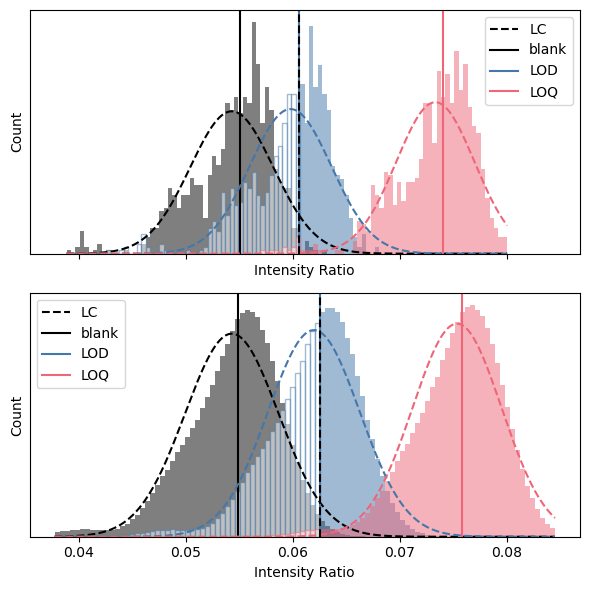

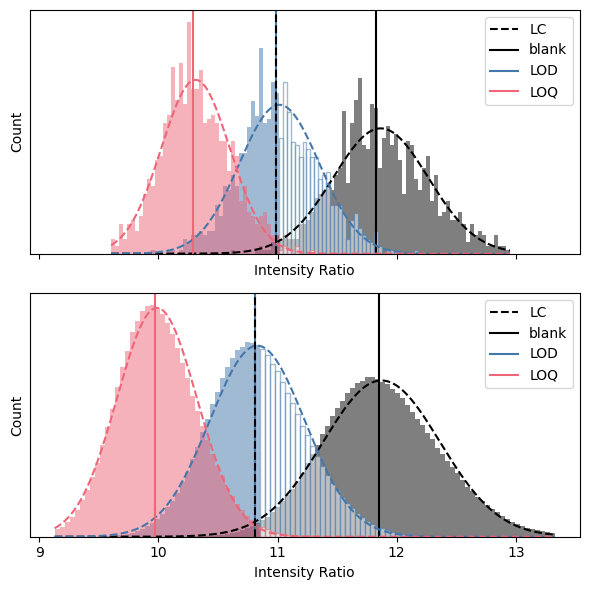

In [6]:
noise = 2.
I1 = 1000.
I2 = 1000.

plot_gaussians = True

threshold = 1    # in percentiles

if skip == True:
    pass
else:
    print("ESTIMATING LIMITS OF DETECTION, QUANTIFICATION")
    
    model = fits[d_key]

    for limit, limit_label in zip(['lower', 'upper'], ['FXB', 'FXJ_JA']):
        print()
        print("%s limits:" % limit)
        char = limit.title()[0]
            
        print()
        print("median %s: %0.1E" % (limit_label, model[limit_label].median))

        LD = get_detection_limit(model, limit=limit, I1=I1, I2=I2, noise=noise, threshold=threshold,
                                 seed=Seed, return_all=True, show_plot=False, tabs=1, debug=False)
        print("    LD (model): %0.1E" % LD['model'])
        print("    LD (noise): %0.1E" % LD['noise'])

        LQ = get_quantification_limit(model, limit=limit, I1=I1, I2=I2, noise=noise, threshold=threshold,
                                      seed=2*Seed, return_all=True, show_plot=False, tabs=1, debug=False)
        print("    LQ (model): %0.1E" % LQ['model'])
        print("    LQ (noise): %0.1E" % LQ['noise'])

        fig, axs = plt.subplots(2, 1, figsize=(6,6), sharex=True)

        for ax, limit_type in zip(axs, ['model', 'noise']):

            blank_CRs = {'upper': np.inf, 'lower': 0.}
            test_CRs = [blank_CRs[limit], LD[limit_type], LQ[limit_type]]

            if limit_type == 'model':
                test_IRs = predict_intensity(model, test_CRs, seed=5*Seed, return_all=True)
            else:
                if limit == 'upper':
                    test_IRs = predict_intensity_noise(model, test_CRs, I1=I1, I2=0, noise=noise, seed=5*Seed, return_all=True)
                else:
                    test_IRs = predict_intensity_noise(model, test_CRs, I1=0, I2=I2, noise=noise, seed=5*Seed, return_all=True)
            print(np.shape(test_IRs))
            
            IR_min = np.nanpercentile(test_IRs, 0.1)
            IR_max = np.nanpercentile(test_IRs, 99.9)

            x_range=(IR_min, IR_max)
            bins = 100
            print("x range: %s - %s" % (IR_min, IR_max))
            
            # get critical value
            if limit == 'upper':
                crit_value = np.nanpercentile(test_IRs[0], threshold)
            else:
                crit_value = np.nanpercentile(test_IRs[0], 100-threshold)

            ax.axvline(crit_value, c='k', linestyle='--', label='LC', zorder=4)
            print("critical value: %0.1E" % crit_value)

            for label, IR, CR, colour in zip(['blank', 'LOD', 'LOQ'], test_IRs, test_CRs, ['k']+Colour_List):
                print()
                print(label, limit_type)
                print("    CR = %0.1E" % CR)
                print("    IR:", np.shape(IR))

                IR_mean = np.nanmean(IR)
                IR_std = np.nanstd(IR)
                IR_median = np.nanmedian(IR)
                IR_lower = np.nanpercentile(IR, threshold)
                IR_upper = np.nanpercentile(IR, 100-threshold)
                print("    median IR: %0.1E" % IR_median)

                if limit == 'upper':
                    FNs = np.count_nonzero(IR > crit_value)
                else:
                    FNs = np.count_nonzero(IR < crit_value)
                print("    FN rate: %3.1f" % (100.*FNs/np.size(IR)))

                ax.axvline(IR_median, c=colour, linestyle='-', label=label)
                bins = 100
                hist, bins, patches = ax.hist(IR, range=x_range, bins=bins, density=True, facecolor=colour, alpha=0.5)
                if CR != 0 and np.isinf(CR) == False:
                    if limit == 'upper':
                        plt.setp([p for p, b in zip(patches, bins) if b > crit_value], facecolor='w', edgecolor=colour)
                    else:
                        plt.setp([p for p, b in zip(patches, bins) if b < crit_value], facecolor='w', edgecolor=colour)

                if plot_gaussians == True:
                    x_temp = np.linspace(bins[0], bins[-1], 1000)
                    # plot expected normal distribution for mean, std
                    params = lmfit.Parameters()
                    params.add('gradient', value=0., vary=False)
                    params.add('intercept', value=0., vary=False)
                    params.add('center_%s' % 0, value=IR_mean, vary=False)
                    params.add('amplitude_%s' % 0, value=np.nanmax(hist))
                    params.add('sigma_%s' % 0, value=IR_std, vary=False)
                    fit = lmfit.minimize(multiG_fit, params, args=((bins[1:]+bins[:-1])/2, hist, [0]))
                    y_temp = multiG_curve(fit.params, x_temp, [0])
                    ax.plot(x_temp, y_temp, c=colour, linestyle='--')

            ax.legend()
            ### ax.set_xscale('log')
            ax.set_xlabel("Intensity Ratio")
            ax.set_ylabel("Count")
            ax.set_yticks([])

        fig.tight_layout()
        if save_plot == True:
            fig.savefig("%sscenario %s_%s-limits.png" % (Fig_dir, Scenario, limit), dpi=300)
            fig.savefig("%sscenario %s_%s-limits.svg" % (Fig_dir, Scenario, limit), dpi=300)
        if show_plot == True:
            fig.show()
        else:
            fit.close()


## Assess Error and Failure Rates


blank CA=0:
    I1: 1.0E+03 +/- 1.4E+02
    I2: 2.0E+04 +/- 1.7E+03

blank CB=0:
    I1: 5.0E+07 +/- 4.8E+06
    I2: 4.9E+06 +/- 5.2E+05

test CR range: 1.0E-07 - 1.1E-01
test CRs: (100,)
test IRs (clean): (100,)
test IRs (noisy): (100, 100)
pred. CRs (clean): (100, 1000)
pred. CRs (noisy): (100, 100000)


/var/folders/54/d2hxt0352h1fr522wqnkkz7c0000gn/T/ipykernel_20765/3042612177.py:59: RuntimeWarning: divide by zero encountered in divide
  CR = np.asarray(CA, dtype=np.float64) / np.asarray(CB, dtype=np.float64)
/Users/joby/Documents/JPL Archive/Quantitative Raman/OSTRI_functions.py:3903: RuntimeWarning: invalid value encountered in divide
  IR = (params["FXJ"] * CR + params["FXB"]) / (params["JA"] * CR + 1)


    LD (model): 2.1E-06 - 5.7E-02
    LD (noise): 7.2E-06 - 2.0E-02
    LQ (model): 7.1E-06 - 2.9E-02
    LQ (noise): 1.5E-05 - 1.0E-02
(np.float64(0.003853368725686847), np.float64(30.491533675058253))


/var/folders/54/d2hxt0352h1fr522wqnkkz7c0000gn/T/ipykernel_20765/2108420091.py:229: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


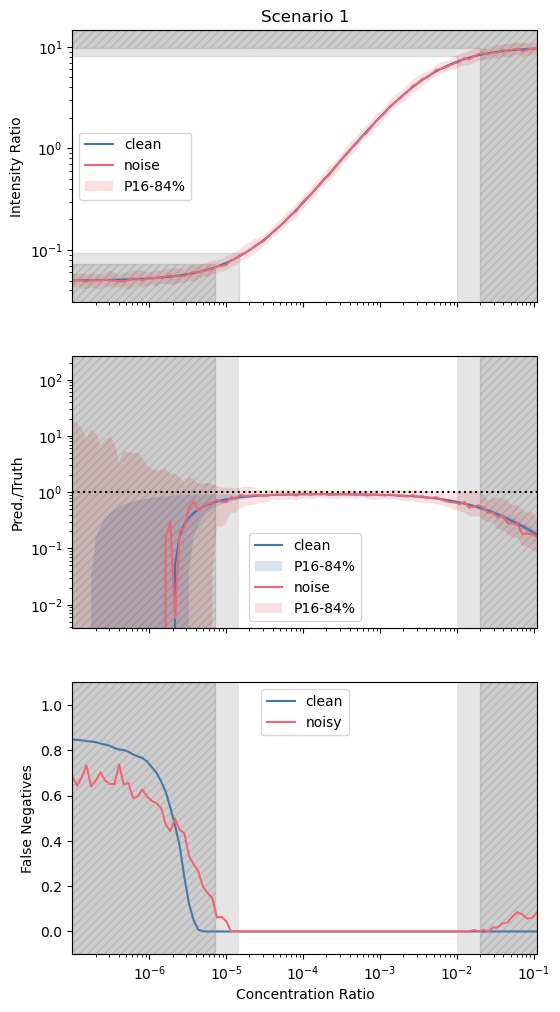

In [7]:

# noise and reference peak levels for estimating noise-driven limits
noise = 150.
I1 = 20000.
I2 = 20000.

# noise levels for simulating test data
N_dark = 100
N_shot = 0.1

# percentiles to use for plotting ranges
percentiles = (16,84)

# limit type to use for plotting limits
limit_type = 'noise'

boxplots = False

# 1 in ni data points will be plotted as a boxplot
ni = 5

# generate blank data
out = generate_data(0, 10**6, Params, 100, dark_noise=N_dark, shot_noise=N_shot, return_all=True)
A0_I1_mean = np.nanmedian(out['I1_noise'])
A0_I1_std = np.nanstd(out['I1_noise'])
A0_I2_mean = np.nanmedian(out['I2_noise'])
A0_I2_std = np.nanstd(out['I2_noise'])
print()
print("blank CA=0:")
print("    I1: %0.1E +/- %0.1E" % (A0_I1_mean, A0_I1_std))
print("    I2: %0.1E +/- %0.1E" % (A0_I2_mean, A0_I2_std))

out = generate_data(10**6, 0., Params, 100, dark_noise=N_dark, shot_noise=N_shot, return_all=True)
B0_I1_mean = np.nanmedian(out['I1_noise'])
B0_I1_std = np.nanstd(out['I1_noise'])
B0_I2_mean = np.nanmedian(out['I2_noise'])
B0_I2_std = np.nanstd(out['I2_noise'])
print()
print("blank CB=0:")
print("    I1: %0.1E +/- %0.1E" % (B0_I1_mean, B0_I1_std))
print("    I2: %0.1E +/- %0.1E" % (B0_I2_mean, B0_I2_std))

# generate test data
test_CA = np.logspace(np.log10(C_min), np.log10(C_max), 100)
test_CB = 10**6 - test_CA
test_CR = test_CA / test_CB

CR_min = np.nanmin(test_CR)
CR_max = np.nanmax(test_CR)

print()
print("test CR range: %0.1E - %0.1E" % (CR_min, CR_max))

# generate noisy IR data
out = generate_data(test_CA, test_CB, Params, 100, dark_noise=N_dark, shot_noise=N_shot, return_all=True)
IR_clean = np.nanmedian(out['IR_clean'], axis=-1)
IR_noise = out['IR_noise']
print("test CRs:", np.shape(test_CR))
print("test IRs (clean):", np.shape(IR_clean))
print("test IRs (noisy):", np.shape(IR_noise))

IR_noise_median = np.nanmedian(IR_noise, axis=-1)
IR_noise_lower = np.nanpercentile(IR_noise, percentiles[0], axis=-1)
IR_noise_upper = np.nanpercentile(IR_noise, percentiles[1], axis=-1)

# predict CR from IR data
CR_pred_clean = predict_concentration(model, IR_clean, percentiles=(16,84), return_all=True, clean_output=False)
print("pred. CRs (clean):", np.shape(CR_pred_clean))
CR_pred_noise = predict_concentration(model, IR_noise, percentiles=(16,84), return_all=True, clean_output=False)
print("pred. CRs (noisy):", np.shape(CR_pred_noise))

CR_pred_clean_median = np.nanmedian(CR_pred_clean, axis=-1)
CR_pred_clean_lower = np.nanpercentile(CR_pred_clean, percentiles[0], axis=-1)
CR_pred_clean_upper = np.nanpercentile(CR_pred_clean, percentiles[1], axis=-1)
CR_pred_noise_median = np.nanmedian(CR_pred_noise, axis=-1)
CR_pred_noise_lower = np.nanpercentile(CR_pred_noise, percentiles[0], axis=-1)
CR_pred_noise_upper = np.nanpercentile(CR_pred_noise, percentiles[1], axis=-1)

# get detection limits
LLD = get_detection_limit(model, limit='lower', I1=I1, I2=I2, noise=noise, threshold=threshold,
                                 seed=Seed, return_all=True, show_plot=False, tabs=1, debug=False)
ULD = get_detection_limit(model, limit='upper', I1=I1, I2=I2, noise=noise, threshold=threshold,
                                 seed=Seed, return_all=True, show_plot=False, tabs=1, debug=False)
print("    LD (model): %0.1E - %0.1E" % (LLD['model'], ULD['model']))
print("    LD (noise): %0.1E - %0.1E" % (LLD['noise'], ULD['noise']))

# get quantification limits
LLQ = get_quantification_limit(model, limit='lower', I1=I1, I2=I2, noise=noise, threshold=threshold,
                                      seed=2*Seed, return_all=True, show_plot=False, tabs=1, debug=False)
ULQ = get_quantification_limit(model, limit='upper', I1=I1, I2=I2, noise=noise, threshold=threshold,
                                      seed=2*Seed, return_all=True, show_plot=False, tabs=1, debug=False)
print("    LQ (model): %0.1E - %0.1E" % (LLQ['model'], ULQ['model']))
print("    LQ (noise): %0.1E - %0.1E" % (LLQ['noise'], ULQ['noise']))

fig, axs = plt.subplots(3, 1, figsize=(6,12), sharex=True, sharey='row', subplot_kw={'xscale': 'log'})

title = "scenario %s" % Scenario

for label, ax, i2 in zip(['Intensity Ratio', 'Rel. Error', 'Failure Rate'], axs, range(3)):
    if i2 == 0:
        # plot test intensity ratios in first ax
        
        # plot all test data as lines
        ax.plot(test_CR, IR_clean, Colour_List[0], label='clean')
        ax.plot(test_CR, IR_noise_median, Colour_List[1], label='noise')
        ax.fill_between(test_CR, IR_noise_lower, IR_noise_upper, facecolor=Colour_List[1],
                        alpha=0.2, label="P%s-%s%%" % (percentiles[0], percentiles[1]))
        
        if boxplots == True:
            # plot data distr as boxplots for subset of test data
            width = lambda p, w: 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)
            ax.boxplot(IR_noise[ni::ni,:].T, positions=test_CR[ni::ni],
                       widths=width(test_CR[ni::ni],0.1), patch_artist=True, showfliers=False, manage_ticks=False,
                       medianprops={'color': 'w'},
                       boxprops={'facecolor': 'gainsboro'},
                       flierprops={'markersize': 4, 'linewidth': 0, 'markerfacecolor': 'k', 'alpha': 0.2}
                      )
        
        # finish subplot
        ax.set_title(title)
        ax.set_yscale('log')
        ax.set_ylabel('Intensity Ratio')
        
        y_min, y_max = ax.get_ylim()
        ax.set_ylim(y_min, y_max)
    elif i2 == 1:
        # plot relative errors in second ax
        
        ax.axhline(1., c='k', linestyle=':')
        
        # plot prediction error for clean test data
        ax.plot(test_CR, CR_pred_clean_median/test_CR, Colour_List[0], label='clean')
        ax.fill_between(test_CR, CR_pred_clean_lower/test_CR, CR_pred_clean_upper/test_CR, facecolor=Colour_List[0],
                        alpha=0.2, label="P%s-%s%%" % (percentiles[0], percentiles[1]))
        
        # plot prediction error for noisy test data
        ax.plot(test_CR, CR_pred_noise_median/test_CR, Colour_List[1], label='noise')
        ax.fill_between(test_CR, CR_pred_noise_lower/test_CR, CR_pred_noise_upper/test_CR, facecolor=Colour_List[1],
                        alpha=0.2, label="P%s-%s%%" % (percentiles[0], percentiles[1]))
        
        if boxplots == True:
            # plot prediction error distr as boxplots for test subset
            y = CR_pred_noise[ni::ni,:]/test_CR[ni::ni,np.newaxis]
            ax.boxplot(y.T, positions=test_CR[ni::ni],
                       widths=width(test_CR[ni::ni],0.1), patch_artist=True, showfliers=False, manage_ticks=False,
                       medianprops={'color': 'w'},
                       boxprops={'facecolor': 'gainsboro'},
                       flierprops={'markersize': 4, 'linewidth': 0, 'markerfacecolor': 'k', 'alpha': 0.2}
                      )
        
        # finish subplot
        ax.set_yscale('log')
        ax.set_ylabel('Pred./Truth')
        
        y_lims = ax.get_ylim()
        y_max = np.amax(np.abs(np.log10(y_lims)))
        print(y_lims)
        ax.set_ylim(10**-y_max, 10**y_max)
        
    elif i2 == 2:
        # plot false negative rate in third ax
        
        # plot FN rate of predictions for noisy test data
        failures = np.count_nonzero(CR_pred_clean < 0, axis=-1)
        ax.plot(test_CR, failures/np.size(CR_pred_clean, axis=-1), Colour_List[0], label='clean')
        
        # plot FN rate of predictions for noisy test data
        failures = np.count_nonzero(CR_pred_noise < 0, axis=-1)
        ax.plot(test_CR, failures/np.size(CR_pred_noise, axis=-1), Colour_List[1], label='noisy')
        
        ax.set_ylim(-0.1, 1.1)
        ax.set_ylabel("False Negatives")
        
        pass
    
    # add detection limits
    if i2 == 0:
        if LLD[limit_type] > 0:
            x = LLD[limit_type]
            y = intensity_curve(model, LLD[limit_type])
            ax.fill(
                [CR_min, CR_min, x, x],
                [y_min, y, y, y_min],
                facecolor='k', edgecolor='k', alpha=0.1, hatch='////'
            )
        if ULD[limit_type] < np.inf:
            x = ULD[limit_type]
            y = intensity_curve(model, ULD[limit_type])
            ax.fill(
                [CR_min, CR_min, CR_max, CR_max, x, x],
                [y, y_max, y_max, y_min, y_min, y],
                facecolor='k', edgecolor='k', alpha=0.1, hatch='////'
            )
    else:
        ax.axvspan(CR_min, LLD[limit_type], facecolor='k', edgecolor='k', alpha=0.1, hatch='////')
        ax.axvspan(ULD[limit_type], CR_max, facecolor='k', edgecolor='k', alpha=0.1, hatch='////')

    # add quantification limits
    if i2 == 0:
        if LLQ[limit_type] > 0:
            x = LLQ[limit_type]
            y = intensity_curve(model, LLQ[limit_type])
            ax.fill(
                [CR_min, CR_min, x, x],
                [y_min, y, y, y_min],
                facecolor='k', edgecolor='k', alpha=0.1
            )
        if ULD[limit_type] < np.inf:
            x = ULQ[limit_type]
            y = intensity_curve(model, ULQ[limit_type])
            ax.fill(
                [CR_min, CR_min, CR_max, CR_max, x, x],
                [y, y_max, y_max, y_min, y_min, y],
                facecolor='k', edgecolor='k', alpha=0.1
            )
    else:
        ax.axvspan(CR_min, LLQ[limit_type], facecolor='k', alpha=0.1)
        ax.axvspan(ULQ[limit_type], CR_max, facecolor='k', alpha=0.1)
    
    ax.set_xlim(CR_min, CR_max)
    ax.legend()
    if i2 == 0:
        ax.set_title("Scenario %s" % Scenario)
    elif i2 == 2:
        ax.set_xlabel("Concentration Ratio")

if save_plot == True:
    fig.savefig("%s%s_prediction-errors.png" % (Fig_dir, title), dpi=300)
if show_plot == True:
    fig.show()
else:
    fig.close()

## Compare Effect of FXJ, FXB, JA

In [8]:
# skip this section?
skip = True

# print debug messages?
debug = True

# plot true parameter values as lines?
plot_truths = True

show_text = False

# show plots in viewer?
show_plot = True

# save plots to file?
save_plot = True

if skip == True:
    print("SKIPPING PARAMETER SPACE MODELLING")
else:
    print("MODELLING PARAMETER SPACE")
    
    # set up data storage arrays
    data = {}
    
    # generate input concentrations (in ppm)
    CA = np.logspace(np.log10(C_min), np.log10(C_max), 100)
    CB = 1000000. - CA
    CR = CA/CB
    
    # parameter range in log space
    amin = 1
    amax = 5
    
    samples = amax - amin + 1
    
    FXJs = np.logspace(amin, amax, samples)
    FXBs = np.logspace(amin-2, amax-2, samples)
    JAs = np.logspace(amin-2, amax-2, samples)
    
    c_min = np.nanmin(np.concatenate([FXJs, FXBs, JAs]))
    c_max = np.nanmax(np.concatenate([FXJs, FXBs, JAs]))
    norm = mpl.colors.LogNorm(vmin=10**np.floor(np.log10(c_min)), vmax=10**np.ceil(np.log10(c_max)))
    
    cm = mpl.colors.LinearSegmentedColormap.from_list("FXJ", [(0,0,0), (1,0,0)], N=256)
    FXJ_cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cm)
    FXJ_cmap.set_array([])
    
    cm = mpl.colors.LinearSegmentedColormap.from_list("FXB", [(0,0,0), (0,1,0)], N=256)
    FXB_cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cm)
    FXB_cmap.set_array([])
    
    cm = mpl.colors.LinearSegmentedColormap.from_list("JA", [(0,0,0), (0,0,1)], N=256)
    JA_cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cm)
    JA_cmap.set_array([])
    
    # create intensity grid
    FXJ, FXB, JA = np.meshgrid(FXJs, FXBs, JAs)
    print(np.shape(FXJs))
    IR = (FXJ[:,:,:,np.newaxis] * CR[np.newaxis, np.newaxis, np.newaxis, :] + FXB[:,:,:,np.newaxis]) / (JA[:,:,:,np.newaxis] * CR[np.newaxis, np.newaxis, np.newaxis, :] + 1)
    check = np.logical_or(IR <= 0, np.isinf(IR))
    IR[check] = np.nan
    print(np.shape(IR))
    
    # determine x,y axis limits
    x_min = 10**np.floor(np.log10(0.9*np.nanmin(CR)))
    x_max = 10**np.ceil(np.log10(1.1*np.nanmax(CR)))
    y_min = 10**np.floor(np.log10(0.9*np.nanmin(IR)))
    y_max = 10**np.ceil(np.log10(1.1*np.nanmax(IR)))
    print("x limits: %0.1E - %0.1E" % (x_min, x_max))
    print("y limits: %0.1E - %0.1E" % (y_min, y_max))
                
    # generate figure
    plt.figure(figsize=(3+samples, 2+samples))
    for xi, FXJ in enumerate(FXJs):
        for yi, FXB in enumerate(FXBs):
            ax = plt.subplot2grid((len(FXBs), 3*len(FXJs)+3), (len(FXBs)-1-yi, 3*xi), colspan=3)
            for zi, JA in enumerate(JAs):
                x = CR
                y = IR[yi,xi,zi]
                color = (xi/len(FXJs), yi/len(FXBs), zi/len(JAs))
                ax.plot(x, y, c=color)
            ax.set_xscale("log")
            ax.set_xlim(x_min, x_max)
            ax.set_yscale("log")
            ax.set_ylim(y_min, y_max)
            ax.set_xticks([])
            ax.set_yticks([])
            if yi == 0:
                plt.xlabel("FXJ=%0.E" % FXJ)
            if xi == 0:
                plt.ylabel("FXB=%0.E" % FXB)
            if FXJ > FXB:
                text = "FXJ > FXB"
                color = 'r'
            elif FXJ < FXB:
                text = "FXJ < FXB"
                color = 'b'
            else:
                text = "FXJ = FXB"
                color = 'k'
            ax.text(0.1, 0.1, text, color=color, transform=ax.transAxes)
    for cmap, label, i in zip([FXJ_cmap, FXB_cmap, JA_cmap], ["FXJ", "FXB", "JA"], range(3)):
        ax = plt.subplot2grid((len(FXBs), 3*len(FXJs)+3), (0, 3*len(FXJs)+i), rowspan=len(FXBs))
        if i == 2:
            plt.colorbar(cmap, cax=ax)
        else:
            plt.colorbar(cmap, cax=ax, ticks=[])
        ax.set_title(label)
    plt.tight_layout(h_pad=0, w_pad=0)
    plt.savefig("%sparameter-test.png" % Fig_dir, dpi=300)
    plt.show()

SKIPPING PARAMETER SPACE MODELLING


## Compare Scenarios 1-4
- this section generates data based on pre-defined parameters for each scenario

In [9]:
# skip this section?
skip = False

# print debug messages?
debug = False

# plot true parameter values as lines?
plot_truths = True

# add parameter values to figures as text? 
show_text = False

# show plots in viewer?
show_plot = True

# save plots to file?
save_plot = True

xo, yo, w, h = (0.18, 0.92, 0.35, 0.06)

if skip == True:
    print("SKIPPING SCENARIO COMPARISON")
else:
    print("COMPARING SCENARIO DATASETS")

    # set up data storage arrays
    data = {}
    fits = {}
    tables = {}

    # generate input concentrations (in ppm)
    CA = np.logspace(np.log10(C_min), np.log10(C_max), int(C_samples))
    CB = 1000000. - CA
    
    table_key = 'basic-fit'
    tables[table_key] = pd.DataFrame(columns=[
        'FXJ Truth', 'FXJ Fit (no noise)', 'FXJ Fit (noise)',
        'FXB Truth', 'FXB Fit (no noise)', 'FXB Fit (noise)',
        'JA Truth', 'JA Fit (no noise)', 'JA Fit (noise)',
        'FXJ_JA Truth', 'FXJ_JA Fit (no noise)', 'FXJ_JA Fit (noise)'
    ])
    
    for scenario in [1, 2, 3, 4]:
        print()
        print("SCENARIO %s" % scenario)
        # key for this dataset
        d_key = 'scenario %s' % scenario

        # ==================================================
        # define parameters

        params = {
            'I_v0': 1.,       # incident laser intensity
            'F_v1': 1.,       # instrument sensitivity factor at v1
            'F_v2': 1.,       # instrument sensitivity factor at v2
            'J_A1': 50.,      # raman cross-section for A, v1
            'J_A2': 5.,       # raman cross-section for A, v2
            'J_B1': 0.001,    # raman cross-section for B, v1
            'J_B2': 0.02,     # raman cross-section for B, v2
            'X_v1': 1.,       # weighted volume factor at v1
            'X_v2': 1.        # weighted volume factor at v2
        }

        if scenario in [2,4]:
            params['J_A2'] = 0.
        if scenario in [3,4]:
            params['J_B1'] = 0.

        truths = get_true_parameters(params['F_v1'] / params['F_v2'],
                                     params['X_v1'] / params['X_v2'],
                                     params['J_A1'] / params['J_B2'],
                                     params['J_A2'] / params['J_A1'],
                                     params['J_B1'] / params['J_B2'])

        print()
        print("    input data parameters")
        for key, val in truths.items():
            print("        %6s: %0.1E" % (key, val))
            tables[table_key].loc[scenario, '%s Truth' % key] = truths[key]

        # ==================================================
        # generate dataset
        
        print()
        print("    generating data...")
        data[d_key] = generate_data(CA, CB, params, N_values, dark_noise=0, shot_noise=0,
                                    seed=Seed+100*int(scenario), return_all=True, tabs=1)
        
        # ==================================================
        # fit ratio
        
        print()
        print("    fitting data...")
        x = data[d_key]['CR']
        y = np.nanmean(data[d_key]['IR_noise'], axis=1)
        fits[d_key] = intensity_fit_script(x, y, truths=truths, return_quantmodel=True, save_plot=False, show_plot=False, debug=False)
        
        for key in ['FXJ', 'FXB', 'JA', 'FXJ_JA']:
            print("        %6s: %0.1E" % (key, fits[d_key][key]))
            tables[table_key].loc[scenario, '%s Fit (no noise)' % key] = fits[d_key][key].value
    
    # save data table to file
    tables[table_key].T.to_csv("%s/Table-%s.csv" % (Out_dir, table_key))
        
    # ==================================================
    # generate summary figure
    
    fig, all_axs = plt.subplots(2, 4, figsize=(12, 7), sharex=True, sharey='row', squeeze=False)
    all_axs = all_axs.T
    
    # determine x,y axis limits
    x_key = 'CR'
    y_keys = [['I1_noise', 'I2_noise'], ['IR_noise'], ['IR_noise']]
    
    x = data[d_key][x_key]
    x_min = 10**(np.floor(np.log10(0.9*np.nanmin(x))))
    x_max = 10**(np.ceil(np.log10(1.1*np.nanmax(x))))
    x_lim = (x_min, x_max)
    y_lims = []
    for i, y_key in enumerate(y_keys):
        print(y_key)
        y = np.ravel(np.asarray([data[d_key][key] for key in y_key]))
        print(np.nanmin(y), np.nanmax(y))
        y_min = 10**(np.floor(np.log10(0.9*np.nanmin(y))))
        y_max = 10**(np.ceil(np.log10(1.1*np.nanmax(y))))
        print(y_min, y_max)
        y_lims.append((y_min, y_max))
    
    # add data to subplots
    for scenario, axs in zip([1, 2, 3, 4], all_axs):
        # key for this dataset
        d_key = 'scenario %s' % scenario
        for axi, ylabel, ax in zip(range(2), ['Intensity', 'Intensity Ratio'], axs):
            if axi == 0:
                ax.set_title(d_key)
            elif axi == 1:
                ax.set_xlabel("Concentration Ratio")
            if scenario == 1:
                ax.set_ylabel(ylabel)
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_xlim(x_lim)
            ax.set_ylim(y_lims[axi])
            
            if axi == 0:
                # plot absolute intensities in first ax
                x_key = 'CR'
                y_keys = ['I1_noise', 'I2_noise']
                labels = ['I1', 'I2']
                for key, label in zip(y_keys, labels):
                        x = data[d_key][x_key]
                        y_av = np.nanmean(data[d_key][key], axis=1)
                        y_err = np.nanstd(data[d_key][key], axis=1)
                        ax.errorbar(x, y_av, yerr=y_err, fmt='none', capsize=3)
                        ax.scatter(x, y_av, label=label)
                
                # add true parameter values
                if show_text == True:
                    ax.text(xo+1*w, yo+h, 'true', ha='right', va='top', transform=ax.transAxes)
                    for i, key in enumerate(['FXJ', 'FXB', 'JA']):
                        ax.text(xo+0*w, yo-i*h, key, ha='right', va='top', transform=ax.transAxes)
                        ax.text(xo+1*w, yo-i*h, "%0.1E" % data[d_key]['truths'][key], ha='right', va='top', transform=ax.transAxes)
                
            elif axi == 1:
                # plot intensity ratio in second ax
                x = data[d_key]['CR']
                y_av = np.nanmean(data[d_key]['IR_noise'], axis=1)
                y_err = np.nanstd(data[d_key]['IR_noise'], axis=1)
                ax.errorbar(x, y_av, c='k', yerr=y_err, fmt='none', capsize=3)
                ax.scatter(x, y_av, c='k', label='IR')
                
                # add asymptote lines
                if plot_truths == True:
                    print()
                    print(d_key)
                    for key in ['FXJ', 'FXB', 'JA']:
                        print("%s: %0.1E" % (key, data[d_key]['truths'][key]))
                    ax.plot(ax.get_xlim(), data[d_key]['truths']['FXJ'] * np.asarray(ax.get_xlim()), 'k:')
                    ax.axhline(data[d_key]['truths']['FXB'], c='k', linestyle=':')
                    ax.axhline(data[d_key]['truths']['FXJ_JA'], c='k', linestyle=':')
                
                # plot fitted line
                x = np.logspace(np.log10(ax.get_xlim()[0]), np.log10(ax.get_xlim()[1]), 100)
                y = intensity_curve(fits[d_key], x)
                ax.plot(x, y, 'r', label='fit')
                
                # add fitted parameter values
                if show_text == True:
                    ax.text(xo+1*w, yo+h, 'fitted', ha='right', va='top', transform=ax.transAxes)
                    for i, key in enumerate(['FXJ', 'FXB', 'JA']):
                        ax.text(xo+0*w, yo-i*h, key, ha='right', va='top', transform=ax.transAxes)
                        ax.text(xo+1*w, yo-i*h, "%0.1E" % fits[d_key][key].value, ha='right', va='top', transform=ax.transAxes)
                
            ax.legend(loc='lower right')
            
    print(tables[table_key].info())
            
    fig.tight_layout(h_pad=0)
    fig.savefig("%ssynthetic_scenarios.png" % Fig_dir, dpi=300)
    fig.savefig("%ssynthetic_scenarios.svg" % Fig_dir, dpi=300)
    fig.show()
    
    print()
    print("DONE")

COMPARING SCENARIO DATASETS

SCENARIO 1

    input data parameters
           FXJ: 2.5E+03
           FXB: 5.0E-02
            JA: 2.5E+02
        FXJ_JA: 1.0E+01

    generating data...

    fitting data...
           FXJ: 2.5E+03
           FXB: 5.0E-02
            JA: 2.5E+02
        FXJ_JA: 1.0E+01

SCENARIO 2

    input data parameters
           FXJ: 2.5E+03
           FXB: 5.0E-02
            JA: 0.0E+00
        FXJ_JA: INF

    generating data...

    fitting data...
           FXJ: 2.5E+03
           FXB: 5.0E-02
            JA: 1.3E-07
        FXJ_JA: 2.0E+10

SCENARIO 3

    input data parameters
           FXJ: 2.5E+03
           FXB: 0.0E+00
            JA: 2.5E+02
        FXJ_JA: 1.0E+01

    generating data...

    fitting data...


/var/folders/54/d2hxt0352h1fr522wqnkkz7c0000gn/T/ipykernel_20765/2223582244.py:99: DeprecationWarning: QuantParameter.__float__ returned non-float (type numpy.float64).  The ability to return an instance of a strict subclass of float is deprecated, and may be removed in a future version of Python.
  print("        %6s: %0.1E" % (key, fits[d_key][key]))
/Users/joby/Documents/JPL Archive/Quantitative Raman/OSTRI_functions.py:2571: RuntimeWarning: divide by zero encountered in scalar divide
  self.relerror = self.error / self.truth
/Users/joby/Documents/JPL Archive/Quantitative Raman/OSTRI_functions.py:2571: RuntimeWarning: invalid value encountered in scalar divide
  self.relerror = self.error / self.truth
/var/folders/54/d2hxt0352h1fr522wqnkkz7c0000gn/T/ipykernel_20765/2223582244.py:99: DeprecationWarning: QuantParameter.__float__ returned non-float (type numpy.float64).  The ability to return an instance of a strict subclass of float is deprecated, and may be removed in a future versio

ZeroDivisionError: 

In [ ]:
def cost_function(model, CR, IR):
    curve = (model["FXJ"] * CR + model["FXB"]) / (model["JA"] * CR + 1)
    cost = np.log10(IR) - np.log10(curve)
    return np.sqrt(np.sum(cost**2))

if skip == True:
    print("SKIPPING SCENARIO COMPARISON")
else:
    print("COMPARING SCENARIO DATASETS")

    # generate input concentrations (in ppm)
    CA = np.logspace(np.log10(C_min), np.log10(C_max), int(C_samples))
    CB = 1000000. - CA
    
    for scenario in [1, 2, 3 , 4]:
        print()
        print("SCENARIO %s" % scenario)
        # key for this dataset
        d_key = 'scenario %s' % scenario

        # ==================================================
        # define parameters

        params = {
            'I_v0': 1.,       # incident laser intensity
            'F_v1': 1.,       # instrument sensitivity factor at v1
            'F_v2': 1.,       # instrument sensitivity factor at v2
            'J_A1': 50.,      # raman cross-section for A, v1
            'J_A2': 5.,       # raman cross-section for A, v2
            'J_B1': 0.001,    # raman cross-section for B, v1
            'J_B2': 0.02,     # raman cross-section for B, v2
            'X_v1': 1.,       # weighted volume factor at v1
            'X_v2': 1.        # weighted volume factor at v2
        }

        if scenario in [2,4]:
            params['J_A2'] = 0.
        if scenario in [3,4]:
            params['J_B1'] = 0.

        truths = get_true_parameters(params['F_v1'] / params['F_v2'],
                                     params['X_v1'] / params['X_v2'],
                                     params['J_A1'] / params['J_B2'],
                                     params['J_A2'] / params['J_A1'],
                                     params['J_B1'] / params['J_B2'])
        
        if scenario == 1:
            limits = {'FXJ': (2000,3000), 'FXB': (0.03, 0.07), 'JA': (150, 350), 'FXJ_JA': (None, None)}
        elif scenario == 2:
            limits = {'FXJ': (2000,3000), 'FXB': (0.03, 0.07), 'JA': (-1, 2), 'FXJ_JA': (None, None)}
        elif scenario == 3:
            limits = {'FXJ': (2000,3000), 'FXB': (-0.0001, 0.0001), 'JA': (150, 350), 'FXJ_JA': (None, None)}
        else:
            limits = {'FXJ': (2000,3000), 'FXB': (-0.0001, 0.0001), 'JA': (-1, 2), 'FXJ_JA': (None, None)}
        
        CR = data[d_key]['CR']
        IR = np.nanmedian(data[d_key]['IR_clean'], axis=1)
        print(np.shape(CR), np.shape(IR))
        
        pairs = combinations(['FXJ', 'FXB', 'JA'], 2)
        
        fig, axs = plt.subplots(3, 1, figsize=(4,9))
        axs[0].set_title(d_key)
        for ax, pair in zip(axs, pairs):
            x_prop, y_prop = pair
            print(x_prop, y_prop)
            
            x_lims = limits[x_prop]
            y_lims = limits[y_prop]
            print("x limits:", x_lims)
            print("y limits:", y_lims)
            
            xs = np.linspace(x_lims[0], x_lims[1], 100)
            ys = np.linspace(y_lims[0], y_lims[1], 100)
            print("x,y coords:", np.shape(xs), np.shape(ys))
            
            img = np.full((np.size(xs), np.size(ys)), np.nan)
            print("img:", np.shape(img))
            
            for xi, x in enumerate(xs):
                for yi, y in enumerate(ys):
                    model = {prop: truths[prop] for prop in ['FXJ', 'FXB', 'JA']}
                    model['log'] = True
                    model[x_prop] = x
                    model[y_prop] = y
                    
                    cost = cost_function(model, CR, IR)
                    
                    img[yi, xi] = np.sqrt(np.sum(cost**2))
                    
            ax.imshow(img, extent=(x_lims[0], x_lims[1], y_lims[1], y_lims[0]), aspect='auto')
            ax.set_box_aspect(1)
            ax.set_xlim(x_lims)
            ax.set_ylim(y_lims)
            ax.set_xlabel(x_prop)
            ax.set_ylabel(y_prop)
            ax.axvline(truths[x_prop], c='w', linestyle=':')
            ax.axhline(truths[y_prop], c='w', linestyle=':')
        
        fig.tight_layout()
        fig.savefig("%scost-function_%s.png" % (Fig_dir, d_key), dpi=300)
        fig.show()

## Compare Scenarios 1-4 with Noise
- this section generates data based on pre-defined parameters for each scenario

In [ ]:
# skip this section?
skip = False

# print debug messages?
debug = True

# plot true parameter values as lines?
plot_truths = True

show_text = False

# show plots in viewer?
show_plot = True

# save plots to file?
save_plot = True

# set up data storage dictionary
data = {}
fits = {}

n_dark = 100.
n_shot = 0.1

xo, yo, w, h = (0.18, 0.92, 0.35, 0.06)

if skip == True:
    print("SKIPPING SCENARIO COMPARISON")
else:
    print("COMPARING SCENARIO DATASETS")

    # generate input concentrations (in ppm)
    CA = np.logspace(np.log10(C_min), np.log10(C_max), int(C_samples))
    CB = 1000000. - CA
    
    for scenario in [1, 2, 3 , 4]:
        print()
        print("SCENARIO %s" % scenario)
        # key for this dataset
        d_key = 'scenario %s' % scenario

        # ==================================================
        # define parameters

        params = {
            'I_v0': 1.,       # incident laser intensity
            'F_v1': 1.,       # instrument sensitivity factor at v1
            'F_v2': 1.,       # instrument sensitivity factor at v2
            'J_A1': 50.,      # raman cross-section for A, v1
            'J_A2': 5.,       # raman cross-section for A, v2
            'J_B1': 0.001,    # raman cross-section for B, v1
            'J_B2': 0.02,     # raman cross-section for B, v2
            'X_v1': 1.,       # weighted volume factor at v1
            'X_v2': 1.        # weighted volume factor at v2
        }

        if scenario in [2,4]:
            params['J_A2'] = 0.
        if scenario in [3,4]:
            params['J_B1'] = 0.

        truths = get_true_parameters(params['F_v1'] / params['F_v2'],
                                     params['X_v1'] / params['X_v2'],
                                     params['J_A1'] / params['J_B2'],
                                     params['J_A2'] / params['J_A1'],
                                     params['J_B1'] / params['J_B2'])

        print()
        print("    input data parameters")
        for key, val in truths.items():
            print("        %6s: %0.1E" % (key, val))

        # ==================================================
        # generate dataset
        
        print()
        print("    generating data...")
        data[d_key] = generate_data(CA, CB, params, N_values, dark_noise=n_dark, shot_noise=n_shot,
                                    seed=Seed+100*int(scenario), return_all=True, tabs=1)
        
        # ==================================================
        # fit ratio
        
        print()
        print("    fitting data...")
        x = data[d_key]['CR']
        y = np.nanmean(data[d_key]['IR_noise'], axis=1)
        fits[d_key] = intensity_fit_script(x, y, truths=truths, return_quantmodel=True, save_plot=False, show_plot=False, debug=False)
        
        for key in ['FXJ', 'FXB', 'JA', 'FXJ_JA']:
            print("        %6s: %0.1E" % (key, fits[d_key][key]))
            tables[table_key].loc[scenario, '%s Fit (noise)' % key] = fits[d_key][key].value
            
    # save data table to file
    tables[table_key].T.to_csv("%s/Table-%s.csv" % (Out_dir, table_key))
        
    # ==================================================
    # generate summary figure
    
    fig, all_axs = plt.subplots(2, 4, figsize=(12, 7), sharex=True, sharey='row', squeeze=False)
    all_axs = all_axs.T
    
    # determine x,y axis limits
    x_key = 'CR'
    y_keys = [['I1_noise', 'I2_noise'], ['IR_noise'], ['IR_noise']]
    
    # add data to subplots
    for scenario, axs in zip([1, 2, 3, 4], all_axs):
        # key for this dataset
        d_key = 'scenario %s' % scenario
        for axi, ylabel, ax in zip(range(2), ['Intensity', 'Intensity Ratio'], axs):
            if axi == 0:
                ax.set_title(d_key)
            elif axi == 1:
                ax.set_xlabel("Concentration Ratio")
            if scenario == 1:
                ax.set_ylabel(ylabel)
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_xlim(x_lim)
            ax.set_ylim(y_lims[axi])
            
            if axi == 0:
                # plot absolute intensities in first ax
                x_key = 'CR'
                y_keys = ['I1_noise', 'I2_noise']
                labels = ['I1', 'I2']
                for key, label in zip(y_keys, labels):
                        x = data[d_key][x_key]
                        y = data[d_key][key]
                        check = np.logical_and(np.isnan(y), y <= 0)
                        y[check] = np.nan
                        y_av = np.nanmean(y, axis=1)
                        y_err = np.nanstd(y, axis=1)
                        ax.errorbar(x, y_av, yerr=y_err, fmt='none', capsize=3)
                        ax.scatter(x, y_av, label=label)
                
                # add true parameter values
                if show_text == True:
                    ax.text(xo, yo+h, 'true', ha='right', va='top', transform=ax.transAxes)
                    for i, key in enumerate(['FXJ', 'FXB', 'JA']):
                        ax.text(xo+0*w, yo-i*h, key, ha='right', va='top', transform=ax.transAxes)
                        ax.text(xo+1*w, yo-i*h, "%0.1E" % data[d_key]['truths'][key], ha='right', va='top', transform=ax.transAxes)
                
            elif axi == 1:
                # plot intensity ratio in second ax
                x = data[d_key]['CR']
                y = data[d_key]['IR_noise']
                check = np.logical_and(np.isnan(y), y <= 0)
                y[check] = np.nan
                y_av = np.nanmean(y, axis=1)
                y_err = np.nanstd(y, axis=1)
                ax.errorbar(x, y_av, c='k', yerr=y_err, fmt='none', capsize=3)
                ax.scatter(x, y_av, c='k', label='IR')
                
                # add asymptote lines
                if plot_truths == True:
                    print()
                    print(d_key)
                    for key in ['FXJ', 'FXB', 'FXJ_JA']:
                        print("%s: %0.1E" % (key, data[d_key]['truths'][key]))
                    ax.plot(ax.get_xlim(), data[d_key]['truths']['FXJ'] * np.asarray(ax.get_xlim()), 'k:')
                    ax.axhline(data[d_key]['truths']['FXB'], c='k', linestyle=':')
                    ax.axhline(data[d_key]['truths']['FXJ_JA'], c='k', linestyle=':')
                
                # plot fitted line
                x = np.logspace(np.log10(ax.get_xlim()[0]), np.log10(ax.get_xlim()[1]), 100)
                y = intensity_curve(fits[d_key], x)
                ax.plot(x, y, 'r', label='fit')
                
                # add fitted parameter values
                if show_text == True:
                    ax.text(xo, yo+h, 'fitted', ha='right', va='top', transform=ax.transAxes)
                    for i, key in enumerate(['FXJ', 'FXB', 'JA']):
                        ax.text(xo+0*w, yo-i*h, key, ha='right', va='top', transform=ax.transAxes)
                        ax.text(xo+1*w, yo-i*h, "%0.1E" % fits[d_key][key].value, ha='right', va='top', transform=ax.transAxes)
                
            ax.legend(loc='lower right')
            
    fig.tight_layout(h_pad=0)
    fig.savefig("%ssynthetic_scenarios_noise.png" % Fig_dir, dpi=300)
    fig.savefig("%ssynthetic_scenarios_noise.svg" % Fig_dir, dpi=300)
    fig.show()
    
    print()
    print("DONE")

## Simulate Effects of Noise

In [ ]:
# skip this section?
skip = True

# print debug messages?
debug = True

# plot true parameter values as lines?
plot_truths = True

show_text = True

# show plots in viewer?
show_plot = True

# save plots to file?
save_plot = True

# set up data storage dictionary
data = {}
fits = {}

# specify scenario
scenario = 4

n_darks = [1., 10., 100., 1000.]
n_shots = [0., 0.1, 0.2, 0.3]

xo, yo, w, h = (0.18, 0.92, 0.35, 0.06)

if skip == True:
    print("SKIPPING NOISE ANALYSIS")
else:
    print("SIMULATING EFFECTS OF NOISE")
    
    print("dark noise levels to evaluate:", n_darks)
    print("shot noise levels to evaluate:", n_shots)
    
    # generate input concentrations (in ppm)
    CA = np.logspace(np.log10(C_min), np.log10(C_max), int(C_samples))
    CB = 1000000. - CA
    
    print()
    print("SCENARIO %s" % scenario)
    
    table_key = 'noise_grid'
    tables[table_key+"_FXJ"] = pd.DataFrame(columns=["Ns=%0.E" % n for n in n_shots], index=["Nd=%0.E" % n for n in n_darks])
    tables[table_key+"_FXB"] = pd.DataFrame(columns=["Ns=%0.E" % n for n in n_shots], index=["Nd=%0.E" % n for n in n_darks])
    tables[table_key+"_JA"] = pd.DataFrame(columns=["Ns=%0.E" % n for n in n_shots], index=["Nd=%0.E" % n for n in n_darks])
    tables[table_key+"_FXJ_JA"] = pd.DataFrame(columns=["Ns=%0.E" % n for n in n_shots], index=["Nd=%0.E" % n for n in n_darks])

    # ==================================================
    # define parameters

    params = {
            'I_v0': 1.,       # incident laser intensity
            'F_v1': 1.,       # instrument sensitivity factor at v1
            'F_v2': 1.,       # instrument sensitivity factor at v2
            'J_A1': 50.,      # raman cross-section for A, v1
            'J_A2': 5.,       # raman cross-section for A, v2
            'J_B1': 0.001,    # raman cross-section for B, v1
            'J_B2': 0.02,     # raman cross-section for B, v2
            'X_v1': 1.,       # weighted volume factor at v1
            'X_v2': 1.        # weighted volume factor at v2
    }

    if scenario in [2,4]:
        params['J_A2'] = 0.
    if scenario in [3,4]:
        params['J_B1'] = 0.

    truths = get_true_parameters(params['F_v1'] / params['F_v2'],
                                     params['X_v1'] / params['X_v2'],
                                     params['J_A1'] / params['J_B2'],
                                     params['J_A2'] / params['J_A1'],
                                     params['J_B1'] / params['J_B2'])
        
    if scenario == 1:
        x_lims = {'FXJ': (2000,3000), 'FXB': (0.03, 0.07), 'JA': (150, 350), 'FXJ_JA': (None, None)}
    elif scenario == 2:
        x_lims = {'FXJ': (2000,3000), 'FXB': (0.03, 0.07), 'JA': (-1, 2), 'FXJ_JA': (None, None)}
    elif scenario == 3:
        x_lims = {'FXJ': (2000,3000), 'FXB': (-0.0001, 0.0001), 'JA': (150, 350), 'FXJ_JA': (None, None)}
    else:
        x_lims = {'FXJ': (2000,3000), 'FXB': (-0.0001, 0.0001), 'JA': (-1, 2), 'FXJ_JA': (None, None)}

    print()
    print("    input data parameters")
    for key, val in truths.items():
        print("        %6s: %0.1E" % (key, val))
        
    count = 1
    for xi, n_shot in enumerate(n_shots):
        for yi, n_dark in enumerate(n_darks):
            # for each noise level
            print()
            print("fitting %s/%s" % (count, len(n_darks)*len(n_shots)))
            print("    scenario %s: Nd=%0.g, Ns=%0.2fx" % (scenario, n_dark, n_shot))

            # key, title for this dataset
            d_key = 'scenario %s_Nd=%0.g_Ns=%0.2f' % (scenario, n_dark, n_shot)
            title = 'scenario %s_Nd=%0.g_Ns=%0.2f' % (scenario, n_dark, n_shot)

            # ==================================================
            # generate dataset

            print()
            print("        generating data...")
            data[d_key] = generate_data(CA, CB, params, N_values, dark_noise=n_dark, shot_noise=n_shot,
                                        seed=Seed + 100*xi + 10*yi, return_all=True, tabs=1)

            # ==================================================
            # fit ratio

            print()
            print("        fitting data...")
            x = data[d_key]['CR']
            y = np.nanmean(data[d_key]['IR_noise'], axis=1)
            fits[d_key] = intensity_fit_script(x, y, truths=truths, return_quantmodel=True, save_plot=False, show_plot=False, debug=False)

            for key in ['FXJ', 'FXB', 'JA', 'FXJ_JA']:
                print("        %6s: %0.1E" % (key, fits[d_key][key]))
                tables["%s_%s" % (table_key, key)].loc["Nd=%0.E" % n_dark, "Ns=%0.E" % n_shot] = fits[d_key][key].value
                
            count += 1
            
    # save data table to file
    for key in ['FXJ', 'FXB', 'JA', 'FXJ_JA']:
        tables["%s_%s" % (table_key, key)].to_csv("%s/Table-%s.csv" % (Out_dir, "%s_%s" % (table_key, key)))
    
    # ==================================================
    # create summary figure for this model
    
    fig, all_axs = plt.subplots(len(n_darks), len(n_shots), figsize=(3+2*len(n_darks), 3+2*len(n_shots)),
                            squeeze=False, sharex=True, sharey=True)
    
    x = data[d_key]['CR']
    x_min = 10**(np.floor(np.log10(0.9*np.nanmin(x))))
    x_max = 10**(np.ceil(np.log10(1.1*np.nanmax(x))))
    x_lim = (x_min, x_max)
    y = np.ravel([np.nanmean(data['scenario %s_Nd=%0.g_Ns=%0.2f' % (scenario, n_dark, n_shot)]['IR_noise'], axis=1)
                  for n_dark in n_darks for n_shot in n_shots])
    check = np.logical_and(y > 0, ~np.isinf(y))
    y_min = 10**(np.floor(np.log10(0.9*np.nanmin(y[check]))))
    y_max = 10**(np.ceil(np.log10(1.1*np.nanmax(y[check]))))
    y_lim = (y_min, y_max)
    
    for axs, n_dark in zip(all_axs, n_darks[::-1]):
        for ax, n_shot in zip(axs, n_shots):
            print()
            print("plotting scenario %s, Nd = %0.1E Ns = %0.1E" % (Scenario, n_dark, n_shot))
            
            # key for this dataset
            d_key = 'scenario %s_Nd=%0.g_Ns=%0.2f' % (scenario, n_dark, n_shot)
            colour = (float(n_darks.index(n_dark))/len(n_darks), 0., float(n_shots.index(n_shot))/len(n_shots))
            
            ax.set_xlim(x_lim)
            ax.set_xscale('log')
            ax.set_xticks([])
            if n_darks.index(n_dark) == 0:
                ax.set_xlabel("$N_{shot}$=%0.1fx" % n_shot)
            ax.set_ylim(y_lim)
            ax.set_yscale('log')
            ax.set_yticks([])
            if n_shots.index(n_shot) == 0:
                ax.set_ylabel("$N_{dark}$=%d" % n_dark)
            
            # plot intensity ratio data
            x = data[d_key]['CR']
            y = data[d_key]['IR_noise']
            check = np.logical_and(np.isnan(y), y <= 0)
            y[check] = np.nan
            y_av = np.nanmean(y, axis=1)
            y_err = np.nanstd(y, axis=1)
            ax.errorbar(x, y_av, c=colour, yerr=y_err, fmt='none', capsize=3)
            ax.scatter(x, y_av, c=colour, label='IR')
                
            # plot fitted line
            x = np.logspace(np.log10(ax.get_xlim()[0]), np.log10(ax.get_xlim()[1]), 100)
            y = intensity_curve(fits[d_key], x)
            ax.plot(x, y, c=colour, label='fit')
                
            # add fitted parameter values
            if show_text == True:
                ax.text(xo+1*w, yo+h, 'fitted', ha='right', va='top', transform=ax.transAxes)
                for i, key in enumerate(['FXJ', 'FXB', 'JA']):
                    ax.text(xo+0*w, yo-i*h, key, ha='right', va='top', transform=ax.transAxes)
                    ax.text(xo+1*w, yo-i*h, "%0.1E" % fits[d_key][key].value, ha='right', va='top', transform=ax.transAxes)
            
    fig.subplots_adjust(0.05, 0.05, 1-0.05, 1-0.05, hspace=0., wspace=0.)
    fig.savefig("%sscenario %s_noise-grid.png" % (Fig_dir, scenario), dpi=300)
    fig.show()

In [ ]:
n_darks = np.logspace(1, 3, 100)
n_shots = np.linspace(0, 0.5, 100)

parameters = {
    'FXJ': np.zeros((np.size(n_darks), np.size(n_shots))),
    'FXB': np.zeros((np.size(n_darks), np.size(n_shots))),
    'JA': np.zeros((np.size(n_darks), np.size(n_shots))),
    'FXJ_JA': np.zeros((np.size(n_darks), np.size(n_shots)))
}

if skip == True:
    print("SKIPPING NOISE ANALYSIS")
else:
    print("SIMULATING EFFECTS OF NOISE")
    
    # ==================================================
    # define parameters

    params = {
                'I_v0': 1.,       # incident laser intensity
                'F_v1': 1.,       # instrument sensitivity factor at v1
                'F_v2': 1.,       # instrument sensitivity factor at v2
                'J_A1': 50.,      # raman cross-section for A, v1
                'J_A2': 5.,       # raman cross-section for A, v2
                'J_B1': 0.001,    # raman cross-section for B, v1
                'J_B2': 0.02,     # raman cross-section for B, v2
                'X_v1': 1.,       # weighted volume factor at v1
                'X_v2': 1.        # weighted volume factor at v2
    }

    if scenario in [2,4]:
        params['J_A2'] = 0.
    if scenario in [3,4]:
        params['J_B1'] = 0.

    truths = get_true_parameters(params['F_v1'] / params['F_v2'],
                                         params['X_v1'] / params['X_v2'],
                                         params['J_A1'] / params['J_B2'],
                                         params['J_A2'] / params['J_A1'],
                                         params['J_B1'] / params['J_B2'])

    if scenario == 1:
        x_lims = {'FXJ': (2000,3000), 'FXB': (0.03, 0.07), 'JA': (150, 350), 'FXJ_JA': (None, None)}
    elif scenario == 2:
        x_lims = {'FXJ': (2000,3000), 'FXB': (0.03, 0.07), 'JA': (-1, 2), 'FXJ_JA': (None, None)}
    elif scenario == 3:
        x_lims = {'FXJ': (2000,3000), 'FXB': (-0.0001, 0.0001), 'JA': (150, 350), 'FXJ_JA': (None, None)}
    else:
        x_lims = {'FXJ': (2000,3000), 'FXB': (-0.0001, 0.0001), 'JA': (-1, 2), 'FXJ_JA': (None, None)}

    print()
    print("    input data parameters")
    for key, val in truths.items():
        print("        %6s: %0.1E" % (key, val))

    count = 1
    for xi, n_dark in enumerate(n_darks):
        for yi, n_shot in enumerate(n_shots):
            # for each noise level
            if count % 100 == 0:
                print("%s/%s models fitted" % (count, np.size(parameters['FXJ'])))
            
            # key, title for this dataset
            d_key = 'scenario %s_Nd=%0.g_Ns=%0.2f' % (scenario, n_dark, n_shot)
            title = 'scenario %s_Nd=%0.g_Ns=%0.2f' % (scenario, n_dark, n_shot)

            # ==================================================
            # generate dataset

            temp_data = generate_data(CA, CB, params, N_values, dark_noise=n_dark, shot_noise=n_shot,
                                        seed=Seed + 100*xi + 10*yi, return_all=True, tabs=1, debug=False)

            # ==================================================
            # fit ratio

            x = temp_data['CR']
            y = np.nanmean(temp_data['IR_noise'], axis=1)
            temp_model = intensity_fit_script(x, y, truths=truths, return_quantmodel=True, save_plot=False, show_plot=False, debug=False)

            for key in ['FXJ', 'FXB', 'JA', 'FXJ_JA']:
                parameters[key][xi,yi] = temp_model[key].value
                
            count += 1
                
    fig, axs = plt.subplots(1, 3, figsize=(12,4), subplot_kw={'projection': '3d', 'sharex': True, 'sharey': True})
    
    for key, ax in zip(['FXJ', 'FXB', 'JA'], axs):
        x, y = np.meshgrid(n_shots, np.log10(n_darks))
        z = parameters[key]
        print(np.shape(x), np.shape(y), np.shape(z))
        ax.plot_surface(x, y, z, cmap='viridis')
        ax.set_xlabel("$N_{shot}$")
        ax.set_ylabel("$log(N_{dark})$")
        ax.set_zlabel(key)
        
    fig.tight_layout()
    fig.savefig("%sscenario %s_noise-grid_parameter-surface.png" % (Fig_dir, scenario), dpi=300)
    fig.show()

## Do Bootstrap Fitting at Different Noise Levels

In [ ]:
# skip this section?
skip = False

# print debug messages?
debug = True

# plot true parameter values as lines?
plot_truths = True

show_text = False

# show plots in viewer?
show_plot = True

# save plots to file?
save_plot = True

# plot covariances from bootstrapping?
plot_covariance = False

# set up data storage dictionary
data = {}
fits = {}

# specify scenario
scenarios = [1, 2, 3, 4]

n_darks = [0.0, 0.0, 0.0]
n_shots = [0.1, 0.2, 0.3]

xo, yo, w, h = (0.18, 0.92, 0.35, 0.06)

if skip == True:
    print("SKIPPING NOISE COMPARISON")
else:
    print("COMPARING NOISE LEVELS")

    # generate input concentrations (in ppm)
    CA = np.logspace(np.log10(C_min), np.log10(C_max), int(C_samples))
    CB = 1000000. - CA
    
    for scenario in scenarios:
        print()
        print("SCENARIO %s" % scenario)
    
        table_key = 'scenario%s_bootstrap-fit' % scenario 
        tables[table_key] = pd.DataFrame(columns=[
            'FXJ Truth', 'FXJ Fit (±0.1x)', 'FXJ Fit (±0.2x)', 'FXJ Fit (±0.3x)',
            'FXB Truth', 'FXB Fit (±0.1x)', 'FXB Fit (±0.2x)', 'FXB Fit (±0.3x)',
            'JA Truth', 'JA Fit (±0.1x)', 'JA Fit (±0.2x)', 'JA Fit (±0.3x)',
            'FXJ_JA Truth', 'FXJ_JA Fit (±0.1x)', 'FXJ_JA Fit (±0.2x)', 'FXJ_JA Fit (±0.3x)',
        ])
        
        # ==================================================
        # define parameters

        params = {
                'I_v0': 1.,       # incident laser intensity
                'F_v1': 1.,       # instrument sensitivity factor at v1
                'F_v2': 1.,       # instrument sensitivity factor at v2
                'J_A1': 50.,      # raman cross-section for A, v1
                'J_A2': 5.,       # raman cross-section for A, v2
                'J_B1': 0.001,    # raman cross-section for B, v1
                'J_B2': 0.02,     # raman cross-section for B, v2
                'X_v1': 1.,       # weighted volume factor at v1
                'X_v2': 1.        # weighted volume factor at v2
        }

        if scenario in [2,4]:
            params['J_A2'] = 0.
        if scenario in [3,4]:
            params['J_B1'] = 0.

        truths = get_true_parameters(params['F_v1'] / params['F_v2'],
                                         params['X_v1'] / params['X_v2'],
                                         params['J_A1'] / params['J_B2'],
                                         params['J_A2'] / params['J_A1'],
                                         params['J_B1'] / params['J_B2'])

        if scenario == 1:
            x_lims = {'FXJ': (2000,3000), 'FXB': (0.03, 0.07), 'JA': (150, 350), 'FXJ_JA': (None, None)}
        elif scenario == 2:
            x_lims = {'FXJ': (2000,3000), 'FXB': (0.03, 0.07), 'JA': (-1, 2), 'FXJ_JA': (None, None)}
        elif scenario == 3:
            x_lims = {'FXJ': (2000,3000), 'FXB': (-0.0001, 0.0001), 'JA': (150, 350), 'FXJ_JA': (None, None)}
        else:
            x_lims = {'FXJ': (2000,3000), 'FXB': (-0.0001, 0.0001), 'JA': (-1, 2), 'FXJ_JA': (None, None)}

        print()
        print("    input data parameters")
        for key, val in truths.items():
            print("        %6s: %0.1E" % (key, val))
            tables[table_key].loc["value", "%s Truth" % (key)] = val

        for ni, n_shot, n_dark in zip(range(len(n_shots)), n_shots, n_darks):
            # for each noise level
            print()
            print("    SCENARIO %s: Nd=%0.g, Ns=%0.2fx" % (scenario, n_dark, n_shot))

            # key, title for this dataset
            d_key = 'scenario %s-%s' % (scenario, ni)
            title = 'scenario %s_Nd=%0.g_Ns=%0.2f' % (scenario, n_dark, n_shot)

            # ==================================================
            # generate dataset

            print()
            print("        generating data...")
            data[d_key] = generate_data(CA, CB, params, N_values, dark_noise=n_dark, shot_noise=n_shot,
                                        seed=Seed + int(scenario), return_all=True, tabs=1)

            # ==================================================
            # fit ratio

            print()
            print("        fitting data...")
            x = data[d_key]['CR']
            y = data[d_key]['IR_noise']
            fits[d_key] = bootstrap_intensity_fit_script(x, y, title=title, truths=truths, x_lims=x_lims, seed=Seed + int(scenario),
                                            plot_covariance=plot_covariance, show_text=show_text,
                                            show_plot=show_plot, save_plot=save_plot, fig_dir=Fig_dir, debug=debug)

            for key in ['FXJ', 'FXB', 'JA', 'FXJ_JA']:
                print("        %6s: %0.1E" % (key, fits[d_key][key]))
                tables[table_key].loc["value", "%s Fit (±%0.1fx)" % (key, n_shot)] = fits[d_key][key].value
                tables[table_key].loc["uncertainty", "%s Fit (±%0.1fx)" % (key, n_shot)] = fits[d_key][key].std

        tables[table_key].T.to_csv("%s/Table-%s.csv" % (Out_dir, table_key))
        
    print("DONE")

## Do Bootstrap Fitting on Scenarios 1-4

In [ ]:
# skip this section?
skip = False

# print debug messages?
debug = False

# plot true parameter values as lines?
plot_truths = True

show_text = False

# show plots in viewer?
show_plot = True

# save plots to file?
save_plot = True

# plot covariances from bootstrapping?
plot_covariance = False

scenarios = [1,2,3,4]

# set up data storage arrays
data = {}
fits = {}

xo, yo, w, h = (0.18, 0.92, 0.35, 0.06)

if skip == True:
    print("SKIPPING BOOTSTRAP FITTING ON SCENARIOS 1-4")
else:
    print("BOOTSTRAP FITTING OF SCENARIOS 1-4")

    # generate input concentrations (in ppm)
    CA = np.logspace(np.log10(C_min), np.log10(C_max), int(C_samples))
    CB = 1000000. - CA
    CR = CA/CB
    
    for scenario in [1, 2, 3 , 4]:
        print()
        print("SCENARIO %s" % scenario)
        # key for this dataset
        d_key = 'scenario %s' % scenario

        # ==================================================
        # define parameters

        params = {
            'I_v0': 1.,       # incident laser intensity
            'F_v1': 1.,       # instrument sensitivity factor at v1
            'F_v2': 1.,       # instrument sensitivity factor at v2
            'J_A1': 50.,      # raman cross-section for A, v1
            'J_A2': 5.,       # raman cross-section for A, v2
            'J_B1': 0.001,    # raman cross-section for B, v1
            'J_B2': 0.02,     # raman cross-section for B, v2
            'X_v1': 1.,       # weighted volume factor at v1
            'X_v2': 1.        # weighted volume factor at v2
        }

        if scenario in [2,4]:
            params['J_A2'] = 0.
        if scenario in [3,4]:
            params['J_B1'] = 0.

        truths = get_true_parameters(params['F_v1'] / params['F_v2'],
                                     params['X_v1'] / params['X_v2'],
                                     params['J_A1'] / params['J_B2'],
                                     params['J_A2'] / params['J_A1'],
                                     params['J_B1'] / params['J_B2'])

        print()
        print("    input data parameters")
        for key, val in truths.items():
            print("        %6s: %0.1E" % (key, val))
            
        if scenario == 1:
            x_lims = {'FXJ': (2000,3000), 'FXB': (0.03, 0.07), 'JA': (150, 350), 'FXJ_JA': (None, None)}
        elif scenario == 2:
            x_lims = {'FXJ': (2000,3000), 'FXB': (0.03, 0.07), 'JA': (-1, 2), 'FXJ_JA': (None, None)}
        elif scenario == 3:
            x_lims = {'FXJ': (2000,3000), 'FXB': (-0.0001, 0.0001), 'JA': (150, 350), 'FXJ_JA': (None, None)}
        else:
            x_lims = {'FXJ': (2000,3000), 'FXB': (-0.0001, 0.0001), 'JA': (-1, 2), 'FXJ_JA': (None, None)}
    
        print()
        print("    input data parameters")
        for key, val in Truths.items():
            print("        %6s: %0.1E" % (key, val))

        # ==================================================
        # generate dataset

        print()
        print("        generating data...")
        data[d_key] = generate_data(CA, CB, params, N_values, dark_noise=Dark_Noise, shot_noise=Shot_Noise,
                                    seed=Seed+10*scenario, return_all=True, tabs=1)

        # ==================================================
        # fit ratio

        print()
        print("        fitting data...")
        x = data[d_key]['CR']
        y = data[d_key]['IR_noise']
        fits[d_key] = bootstrap_intensity_fit_script(x, y, title=title, truths=truths, x_lims=x_lims, plot_covariance=plot_covariance,
                                        seed=Seed+10*scenario, show_text=show_text, show_plot=show_plot, save_plot=save_plot, fig_dir=Fig_dir, debug=debug)

        for key in ['FXJ', 'FXB', 'JA', 'FXJ_JA']:
            param = fits[d_key][key]
            print("        %6s (16-84%%): %0.2E (%0.2E - %0.2E)" % (key, param.median, np.percentile(param.bootstrap, 16), np.percentile(param.bootstrap, 84)))
        
    print("DONE")

## Report Model Effectiveness

In [ ]:

# noise levels for simulating test data
N_dark = 100
N_shot = 0.1

# percentiles to use for plotting ranges
percentiles = (16,84)

# limit type to use for plotting limits
limit_type = 'overall'

boxplots = False

# 1 in ni data points will be plotted as a boxplot
ni = 5

temp_data = {}

if skip == True:
    print("SKIPPING SUMMARY FIGURE FOR SCENARIOS 1-4")
else:
    print("PLOTTING SUMMARY FIGURE FOR SCENARIOS 1-4")
    
    # generate test data
    test_CA = np.logspace(np.log10(C_min), np.log10(C_max), 100)
    test_CB = 10**6 - test_CA
    test_CR = test_CA / test_CB

    CR_min = np.nanmin(test_CR)
    CR_max = np.nanmax(test_CR)

    fig, all_axs = plt.subplots(3, 4, figsize=(12,9), sharex=True, sharey='row', subplot_kw={'xscale': 'log'}, squeeze=False)
    all_axs = all_axs.T
    print(np.shape(all_axs))
    
    # generate broadest dataset (scenario 4) for determining y_lim
    
    params = {
                    'I_v0': 1.,       # incident laser intensity
                    'F_v1': 1.,       # instrument sensitivity factor at v1
                    'F_v2': 1.,       # instrument sensitivity factor at v2
                    'J_A1': 50.,      # raman cross-section for A, v1
                    'J_A2': 0.,       # raman cross-section for A, v2
                    'J_B1': 0,        # raman cross-section for B, v1
                    'J_B2': 0.02,     # raman cross-section for B, v2
                    'X_v1': 1.,       # weighted volume factor at v1
                    'X_v2': 1.        # weighted volume factor at v2
    }
    
    out = generate_data(test_CA, test_CB, params, 100, dark_noise=N_dark, shot_noise=N_shot, return_all=False)
    y = np.nanmedian(out['IR_clean'], axis=-1)
    check = y > 0
    y[~check] = np.nan
    print(np.nanmin(y), np.nanmax(y))
    IR_min = 10**np.floor(np.log10(0.9*np.nanmin(y)))
    IR_max = 10**np.ceil(np.log10(1.1*np.nanmax(y)))

    for i, scenario, axs in zip(range(len(scenarios)), scenarios, all_axs):
        title = "scenario %s" % scenario
        d_key = 'scenario %s' % scenario
        print()
        print(title)

        # get model
        model = fits[d_key]

        # ==================================================
        # define parameters

        params = {
                    'I_v0': 1.,       # incident laser intensity
                    'F_v1': 1.,       # instrument sensitivity factor at v1
                    'F_v2': 1.,       # instrument sensitivity factor at v2
                    'J_A1': 50.,      # raman cross-section for A, v1
                    'J_A2': 5.,       # raman cross-section for A, v2
                    'J_B1': 0.001,    # raman cross-section for B, v1
                    'J_B2': 0.02,     # raman cross-section for B, v2
                    'X_v1': 1.,       # weighted volume factor at v1
                    'X_v2': 1.        # weighted volume factor at v2
        }

        if scenario in [2,4]:
            params['J_A2'] = 0.
        if scenario in [3,4]:
            params['J_B1'] = 0.

        truths = get_true_parameters(params['F_v1'] / params['F_v2'],
                                             params['X_v1'] / params['X_v2'],
                                             params['J_A1'] / params['J_B2'],
                                             params['J_A2'] / params['J_A1'],
                                             params['J_B1'] / params['J_B2'])

        # generate blank test data for CA = 0
        out = generate_data(0, 10**6, params, 100, dark_noise=N_dark, shot_noise=N_shot, seed=Seed+10, return_all=True)
        A0_I1_mean = np.nanmedian(out['I1_noise'])
        A0_I1_std = np.nanstd(out['I1_noise'])
        A0_I2_mean = np.nanmedian(out['I2_noise'])
        A0_I2_std = np.nanstd(out['I2_noise'])
        if debug == True:
            print()
            print("blank CA=0:")
            print("    I1: %0.1E +/- %0.1E" % (A0_I1_mean, A0_I1_std))
            print("    I2: %0.1E +/- %0.1E" % (A0_I2_mean, A0_I2_std))

        # generate blank test data for CB = 0
        out = generate_data(10**6, 0., params, 100, dark_noise=N_dark, shot_noise=N_shot, seed=Seed+20, return_all=True)
        B0_I1_mean = np.nanmedian(out['I1_noise'])
        B0_I1_std = np.nanstd(out['I1_noise'])
        B0_I2_mean = np.nanmedian(out['I2_noise'])
        B0_I2_std = np.nanstd(out['I2_noise'])
        if debug == True:
            print()
            print("blank CB=0:")
            print("    I1: %0.1E +/- %0.1E" % (B0_I1_mean, B0_I1_std))
            print("    I2: %0.1E +/- %0.1E" % (B0_I2_mean, B0_I2_std))

        # assign values for noise-driven limit estimation
        noise = A0_I1_std
        I1 = B0_I1_mean
        I2 = A0_I2_mean

        print()
        print("test CR range: %0.1E - %0.1E" % (CR_min, CR_max))

        # generate noisy IR data
        out = generate_data(test_CA, test_CB, params, 100, dark_noise=N_dark, shot_noise=N_shot, seed=Seed+50, return_all=True)
        IR_clean = np.nanmedian(out['IR_clean'], axis=-1)
        IR_noise = out['IR_noise']
        if debug == True:
            print("test CRs:", np.shape(test_CR))
            print("test IRs (clean):", np.shape(IR_clean))
            print("test IRs (noisy):", np.shape(IR_noise))

        IR_noise_median = np.nanmedian(IR_noise, axis=-1)
        IR_noise_lower = np.nanpercentile(IR_noise, percentiles[0], axis=-1)
        IR_noise_upper = np.nanpercentile(IR_noise, percentiles[1], axis=-1)

        # predict CR from IR data
        CR_pred_clean = predict_concentration(model, IR_clean, percentiles=(16,84), return_all=True, clean_output=False)
        CR_pred_noise = predict_concentration(model, IR_noise, percentiles=(16,84), return_all=True, clean_output=False)
        if debug == True:
            print("pred. CRs (clean):", np.shape(CR_pred_clean))
            print("pred. CRs (noisy):", np.shape(CR_pred_noise))

        CR_pred_clean_median = np.nanmedian(CR_pred_clean, axis=-1)
        CR_pred_clean_lower = np.nanpercentile(CR_pred_clean, percentiles[0], axis=-1)
        CR_pred_clean_upper = np.nanpercentile(CR_pred_clean, percentiles[1], axis=-1)
        CR_pred_noise_median = np.nanmedian(CR_pred_noise, axis=-1)
        CR_pred_noise_lower = np.nanpercentile(CR_pred_noise, percentiles[0], axis=-1)
        CR_pred_noise_upper = np.nanpercentile(CR_pred_noise, percentiles[1], axis=-1)

        # get detection limits
        LLD = get_detection_limit(model, limit='lower', I1=I1, I2=I2, noise=noise, threshold=threshold,
                                         seed=Seed, return_all=True, show_plot=False, tabs=1, debug=False)
        ULD = get_detection_limit(model, limit='upper', I1=I1, I2=I2, noise=noise, threshold=threshold,
                                         seed=Seed, return_all=True, show_plot=False, tabs=1, debug=False)
        print("    LD (model): %0.1E - %0.1E" % (LLD['model'], ULD['model']))
        print("    LD (noise): %0.1E - %0.1E" % (LLD['noise'], ULD['noise']))

        # get quantification limits
        LLQ = get_quantification_limit(model, limit='lower', I1=I1, I2=I2, noise=noise, threshold=threshold,
                                              seed=2*Seed, return_all=True, show_plot=False, tabs=1, debug=False)
        ULQ = get_quantification_limit(model, limit='upper', I1=I1, I2=I2, noise=noise, threshold=threshold,
                                              seed=2*Seed, return_all=True, show_plot=False, tabs=1, debug=False)
        print("    LQ (model): %0.1E - %0.1E" % (LLQ['model'], ULQ['model']))
        print("    LQ (noise): %0.1E - %0.1E" % (LLQ['noise'], ULQ['noise']))

        for label, ax, i2 in zip(['Intensity Ratio', 'Rel. Error', 'Failure Rate'], axs, range(3)):
            if i2 == 0:
                # plot test intensity ratios in first ax

                # plot all test data as lines
                ax.plot(test_CR, IR_noise_median, Colour_List[1], label='noise')
                ax.plot(test_CR, IR_clean, Colour_List[0], label='clean')
                ax.fill_between(test_CR, IR_noise_lower, IR_noise_upper, facecolor=Colour_List[1],
                                alpha=0.33, label="P%s-%s%%" % (percentiles[0], percentiles[1]))

                if boxplots == True:
                    # plot data distr as boxplots for subset of test data
                    width = lambda p, w: 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)
                    ax.boxplot(IR_noise[ni::ni,:].T, positions=test_CR[ni::ni],
                               widths=width(test_CR[ni::ni],0.1), patch_artist=True, showfliers=False, manage_ticks=False,
                               medianprops={'color': 'w'},
                               boxprops={'facecolor': 'gainsboro'},
                               flierprops={'markersize': 4, 'linewidth': 0, 'markerfacecolor': 'k', 'alpha': 0.2}
                              )

                # finish subplot
                ax.set_yscale('log')
                ax.set_ylim(IR_min, IR_max)
                if i == 0:
                    ax.set_ylabel('Intensity Ratio')

            elif i2 == 1:
                # plot relative errors in second ax

                ax.axhline(1., c='k', linestyle=':')

                # plot prediction error for noisy test data
                ax.plot(test_CR, CR_pred_noise_median/test_CR, Colour_List[1], label='noise')
                ax.fill_between(test_CR, CR_pred_noise_lower/test_CR, CR_pred_noise_upper/test_CR, facecolor=Colour_List[1],
                                alpha=0.33, label="P%s-%s%%" % (percentiles[0], percentiles[1]))
                
                # plot prediction error for clean test data
                ax.plot(test_CR, CR_pred_clean_median/test_CR, Colour_List[0], label='clean')
                ax.fill_between(test_CR, CR_pred_clean_lower/test_CR, CR_pred_clean_upper/test_CR, facecolor=Colour_List[0],
                                alpha=0.33, label="P%s-%s%%" % (percentiles[0], percentiles[1]))
                
                # add to storage array
                temp_data[d_key] = {
                    'CR': test_CR,
                    'clean': CR_pred_clean / test_CR[...,np.newaxis],
                    'noise': CR_pred_noise / test_CR[...,np.newaxis]
                }

                if boxplots == True:
                    # plot prediction error distr as boxplots for test subset
                    y = CR_pred_noise[ni::ni,:]/test_CR[ni::ni,np.newaxis]
                    ax.boxplot(y.T, positions=test_CR[ni::ni],
                               widths=width(test_CR[ni::ni],0.1), patch_artist=True, showfliers=False, manage_ticks=False,
                               medianprops={'color': 'w'},
                               boxprops={'facecolor': 'gainsboro'},
                               flierprops={'markersize': 4, 'linewidth': 0, 'markerfacecolor': 'k', 'alpha': 0.2}
                              )

                # finish subplot
                ax.set_yscale('log')
                if i == 0:
                    ax.set_ylabel('Pred./Truth')
                
                ax.set_ylim(10**-1, 10**1)

            elif i2 == 2:
                # plot false negative rate in third ax

                # plot negative predictions for clean test data
                failures = np.count_nonzero(CR_pred_clean < 0, axis=-1)
                ax.plot(test_CR, 100*failures/np.size(CR_pred_clean, axis=-1), Colour_List[0], linestyle=':', label='<0 (clean)')

                # plot negative predictions for noisy test data
                failures = np.count_nonzero(CR_pred_noise < 0, axis=-1)
                ax.plot(test_CR, 100*failures/np.size(CR_pred_noise, axis=-1), Colour_List[1], linestyle=':', label='<0 (noisy)')
                
                # plot false negatives of predictions for clean test data
                failures = np.count_nonzero(np.logical_or(CR_pred_clean < LLD['model'], CR_pred_clean > ULD[limit_type]), axis=-1)
                ax.plot(test_CR, 100*failures/np.size(CR_pred_clean, axis=-1), Colour_List[0], linestyle='--', label='FN (clean)')
                
                # plot false negatives of predictions for noisy test data
                failures = np.count_nonzero(np.logical_or(CR_pred_noise < LLD['noise'], CR_pred_noise > ULD[limit_type]), axis=-1)
                ax.plot(test_CR, 100*failures/np.size(CR_pred_noise, axis=-1), Colour_List[1], linestyle='--', label='FN (noisy)')
                
                ax.set_ylim(-10, 110)
                if i == 0:
                    ax.set_ylabel("% of Predictions")

                pass

            # add detection limits
            if i2 == 0:
                if LLD[limit_type] > 0:
                    x = LLD[limit_type]
                    y = intensity_curve(model, LLD[limit_type])
                    ax.fill(
                        [CR_min, CR_min, x, x],
                        [IR_min, y, y, IR_min],
                        facecolor='k', edgecolor='k', linewidth=0., alpha=0.1, hatch='////'
                    )
                if ULD[limit_type] < np.inf:
                    x = ULD[limit_type]
                    y = intensity_curve(model, ULD[limit_type])
                    ax.fill(
                        [CR_min, CR_min, CR_max, CR_max, x, x],
                        [y, IR_max, IR_max, IR_min, IR_min, y],
                        facecolor='k', edgecolor='k', linewidth=0., alpha=0.1, hatch='////'
                    )
            else:
                ax.axvspan(CR_min, LLD[limit_type], facecolor='k', edgecolor='k', linewidth=0., alpha=0.1, hatch='////')
                ax.axvspan(ULD[limit_type], CR_max, facecolor='k', edgecolor='k', linewidth=0., alpha=0.1, hatch='////')

            # add quantification limits
            if i2 == 0:
                if LLQ[limit_type] > 0:
                    x = LLQ[limit_type]
                    y = intensity_curve(model, LLQ[limit_type])
                    ax.fill(
                        [CR_min, CR_min, x, x],
                        [IR_min, y, y, IR_min],
                        facecolor='k', edgecolor='k', linewidth=0., alpha=0.1
                    )
                if ULD[limit_type] < np.inf:
                    x = ULQ[limit_type]
                    y = intensity_curve(model, ULQ[limit_type])
                    ax.fill(
                        [CR_min, CR_min, CR_max, CR_max, x, x],
                        [y, IR_max, IR_max, IR_min, IR_min, y],
                        facecolor='k', edgecolor='k', linewidth=0., alpha=0.1
                    )
            else:
                ax.axvspan(CR_min, LLQ[limit_type], facecolor='k', linewidth=0., alpha=0.1)
                ax.axvspan(ULQ[limit_type], CR_max, facecolor='k', linewidth=0., alpha=0.1)

            ax.set_xlim(CR_min, CR_max)
            ### ax.set_xticks(np.logspace(np.log10(CR_min), np.log10(CR_max), int(np.log10(CR_max)-np.log10(CR_min)+1)))
            ax.legend()
            if i2 == 0:
                ax.set_title("Scenario %s" % scenario)
            elif i2 == 2:
                ax.set_xlabel("True Concentration Ratio")

    fig.tight_layout(h_pad=0, w_pad=0)
    if save_plot == True:
        fig.savefig("%ssynthetic_scenarios_prediction-errors.png" % Fig_dir, dpi=300)
        fig.savefig("%ssynthetic_scenarios_prediction-errors.svg" % Fig_dir, dpi=300)
    if show_plot == True:
        fig.show()
    else:
        fig.close()

In [ ]:


for d_key, temp in temp_data.items():
    plt.title(d_key)
    plt.plot(temp['CR'], np.abs(np.log10(np.nanmedian(temp['clean'], axis=-1))), label='clean')
    plt.plot(temp['CR'], np.abs(np.log10(np.nanmedian(temp['noise'], axis=-1))), label='noise')
    plt.axhline(0.1, c='k', linestyle=':')
    plt.xscale('log')
    plt.legend()
    plt.show()
    
for d_key, temp in temp_data.items():
    x_ranges = [(1*10**-6, 6*10**-2), (1*10**-5, 6*10**-2)]
    RMSPE = np.sqrt(np.nanmean(np.log10(np.nanmedian(temp['clean'], axis=-1)))**2)
    print(d_key)
    print("    clean RMSPE: %0.3f" % RMSPE, "(%0.2f-%0.2fx)" % (10**-RMSPE, 10**RMSPE))
    RMSPE = np.sqrt(np.nanmean(np.log10(np.nanmedian(temp['noise'], axis=-1)))**2)
    print("    noisy RMSPE: %0.3f" % RMSPE, "(%0.2f-%0.2fx)" % (10**-RMSPE, 10**RMSPE))
    for x_range in x_ranges:
        print("    ", x_range)
        result = np.logical_and(x_range[0] <= temp['CR'], temp['CR'] <= x_range[1])
        RMSPE = np.sqrt(np.nanmean(np.log10(np.nanmedian(temp['clean'], axis=-1)[result]))**2)
        print("        clean RMSPE: %0.3f" % RMSPE, "(%0.2f-%0.2fx)" % (10**-RMSPE, 10**RMSPE))
        RMSPE = np.sqrt(np.nanmean(np.log10(np.nanmedian(temp['noise'], axis=-1)[result]))**2)
        print("        noisy RMSPE: %0.3f" % RMSPE, "(%0.2f-%0.2fx)" % (10**-RMSPE, 10**RMSPE))
    

## Save tables

In [ ]:
for title, table in tables.items():
    print("Table-%s" % title, np.shape(table.T))
    print(table.T)
    table.T.to_csv("%s/Table-%s.csv" % (Out_dir, title))
    
    
print()
print("DONE")